In [1]:
## HIDE CODE: 

from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## ANLT 234 ~ Analytics Storytelling
### Homework 4 ~ Fully Reproducible Presentation of Visual Story
 
**Submitted by Heather Steich**  
**Due April 16th, 2016 @ 11:30PM**  
***Version: Python 3***

---

---

# Slide 1:


## AGE: IS IT *REALLY* JUST A NUMBER?

Heather Steich  
April 16th, 2016  
University of the Pacific ~ ANLT 234 ~ Analytics Storytelling

---


# Slide 1 Narrative:

ANLT 234 ~ Analytics Storytelling  
Homework 4 ~ Presentation of Visual Story  
   
Submitted by Heather Steich  
Due April 16th, 2016 @ 11:30PM   

---

---

# Slide 2:


## Data Overview & Preparation

 - Raw Administrative Insurance Claims Data from Pharmetrics$_TM$  
  
 - Over 1.7 million Insurance Claims for over 5,800 Patients  
  
 - Raw Claims Merged with Features from  
    - Enrollment Demographics  
    - Prescription Codes  
    - Diagnosis Codes  
    - Procedure Codes  
<img src='HW4_Files/med_file.png'>

In [2]:
## LOAD LIBRARIES:

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
## DATA PREPARATION:

# Load in the data:
claims_raw = pd.DataFrame(pd.read_csv("HW4_Files/uopjan16_claims_in.csv"))
enroll = pd.DataFrame(pd.read_csv("HW4_Files/uopjan16_enroll_in.csv"))
rx = pd.DataFrame(pd.read_csv("HW4_Files/uopjanref_rx_lookup.csv", skiprows=1))
diag = pd.DataFrame(pd.read_csv("HW4_Files/uopjanref_diag_lookup.csv"))
proc = pd.DataFrame(pd.read_csv("HW4_Files/uopjanref_proc_lookup.csv"))

# Merge the Claims & abbreviated Enrollment DataFrames:
enroll_abbrev = pd.DataFrame(enroll, columns=['pat_id', 'der_sex', 'der_yob', 'nbr_clms', 'pat_region'])
claims2 = pd.merge(claims_raw, enroll_abbrev, how="left", on='pat_id')

# Merge the Claims & abbreviated Rx DataFrames:
# NDC: National Drug Code
rx_abbrev = pd.DataFrame(rx, columns=['National Drug Code', 'rx_group', 'drug_class', 'brand_name', 'gen_nm'])
claims3 = pd.merge(claims2, rx_abbrev, how="left", left_on='ndc', right_on='National Drug Code')

# Merge the Claims & abbreviated Diagnosis Code DataFrames:
# ICD - 9: International Classification of Diseases, 9th revision
diag_abbrev = diag.reset_index()
diag_abbrev = diag_abbrev.drop('CSV Output', axis=1)
diag_abbrev = diag_abbrev.drop([0], axis=0)
diag_abbrev.columns = ['diag', 'diag_descrip']
claims4 = pd.merge(claims3, diag_abbrev, how="left", left_on='diag1', right_on='diag')
claims4.rename(columns={'diag': 'diag_1', 'diag_descrip': 'diag1_descrip'}, inplace=True)
claims5 = pd.merge(claims4, diag_abbrev, how="left", left_on='diag2', right_on='diag')
claims5.rename(columns={'diag': 'diag_2', 'diag_descrip': 'diag2_descrip'}, inplace=True)
claims6 = pd.merge(claims5, diag_abbrev, how="left", left_on='diag3', right_on='diag')
claims6.rename(columns={'diag': 'diag_3', 'diag_descrip': 'diag3_descrip'}, inplace=True)
claims7 = pd.merge(claims6, diag_abbrev, how="left", left_on='diag4', right_on='diag')
claims7.rename(columns={'diag': 'diag_4', 'diag_descrip': 'diag4_descrip'}, inplace=True)

# Merge the Claims & abbreviated Procedure Code DataFrames:
###NOTE:
# On the original merge, using left outer join, the number of rows increased by over 40K.  After looking further, there were 55
# duplicated procedure codes, all classified as "UNKNOWN Code" or "Revenue Code."  
#proc[proc.duplicated(subset=['CSV Output'])]
# The revised merge function (below) now drops duplicates, keeping the first occurrence by default, and returns the new claims
# DataFrame with the row counts preserved.
proc_abbrev = proc.drop('Unnamed: 1', axis=1)
proc_abbrev.columns = ['proc_cde', 'proc_descrip']
claims8 = pd.merge(claims7, proc_abbrev.drop_duplicates('proc_cde'), how="left", on='proc_cde')

# Drop excess &/or redundant columns:
claims = claims8.drop(['ndc', 'cluspvid', 'conf_num', 'ptypeflg', 'rectype', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 
                       'rec_ix'], axis=1)

# Rename remaining columns for clarity:
claims.rename(columns={'rec_spec': 'specialist', 'ALLOWED': 'allowed_fee', 'DAYSSUP': 'days_supply', 'QUAN': 'quantity', 
                      'paid': 'insur_paid', 'der_sex': 'sex', 'der_yob': 'yob', 'National Drug Code': 'ndc', 'brand_name': 
                      'brand_nm'}, inplace=True)

# Reorder columns for clarity:
claims = claims[['pat_id', 'sex', 'yob', 'pat_region', 'from_dt', 'to_dt', 'prov_id', 'specialist', 'pos', 'proc_cde', 
                 'proc_descrip', 'diag1', 'diag1_descrip', 'diag2', 'diag2_descrip', 'diag3', 'diag3_descrip', 'diag4', 
                 'diag4_descrip', 'ndc', 'rx_group', 'drug_class', 'brand_nm', 'gen_nm', 'days_supply', 'quantity', 
                 'charge', 'allowed_fee', 'insur_paid', 'nbr_clms']]

# Coerce appropriate data types where appropriate:
claims['from_dt'] = claims.from_dt.convert_objects(convert_dates='coerce')
claims['to_dt'] = claims.to_dt.convert_objects(convert_dates='coerce')

In [4]:
## ESTABLISH PLOT FORMATTING:

#mpl.rcdefaults()  # Resets plot defaults

def plt_format():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (16, 10)
    plt.rcParams['font.size'] = 16
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.markerscale'] = 4
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['axes.linewidth'] = 1

#plt.rcParams.keys()  # Available rcParams
plt_format()

---

# Slide 2 Narrative:
  
#### Data Preparation  
  
This project will utilize raw administrative claims data from PharmetricsTM.  This is a very rich data set containing over 5,800 unique patients, and over 1.7 million insurance claims.  The patients are all on antidiabetic and/or anticoagulant medications, two populations of patients that may be at particular risk of adverse health events.  
  
The raw claims file is interesting as-is, but to make it 'meatier' I'll pull in some patient demographic features from the insurance enrollment DataFrame, merged on the unique alphanumeric patient IDs.  For added clarity, details and descriptions from the prescription code, diagnosis code, and procedure code files are incorporated.  Lastly, I complete some basic organization and formatting to prepare for analysis and report writing.  

---

---

# Slide 3:


## Age & Aging

**age**  ( "āj" )  
*Noun*  
1. the length of time that a person has lived or a thing has existed.   
 - "he died from a heart attack at the age of 51"   
2. a distinct period of history.  
 - "an age of technological growth"    
  
*Verb*    
1. grow old or older, especially visibly and obviously so.  
 - "you haven't aged a lot"  

*Source: Google search for "age definition"*

<img src='HW4_Files/family.png'>

---

# Slide 3 Narrative:

#### Introduction  
  
Life has many stages, many milestones and many events along the way.  From the second of conception, from the very first time a baby fills their lungs, to the screams on the playground, the gleeful shriek after nailing the first chemistry exam, to the very last cry; life touches every one of us.  Age is one way to measure a life over time.  
  
When it comes to healthcare/life care, what does age mean?  Does it correlate to other factors like cost, number of medications, number of procedures, etcetera?  Does increasing age directly increase risk for medical complications and diseases?  This is a very complex topic, and one that cannot be summarized in one report alone.  Yet, given enough data on enough patients over enough time, perhaps it is possible to predict a patient's health as they age, but this prompts another question of how much is "enough" data?  

---

---

# Slide 4:


## World Health

 - World Health Organization  
    - Specialized agency of the United Nations concerned with international public health  
    - Established on April 7th,1948  
    - Headquartered in Geneva, Switzerland  
 - World Health Day  
    - April 7th, 2016  
    - Theme: Diabetes Awareness  
 - PharmetricsTM Data Set  
    - All patients on antidiabetic &/or anticoagulant medications  
    - 2 populations of patients that may be at risk of adverse health events  

*Source: http://www.who.int/campaigns/world-health-day/2016/how-to-get-involved/en/*

<img src='HW4_Files/world.png'>

---

# Slide 4 Narrative:


#### Introduction (continued)  
  
The data set is not a truly random sample of the population because the patients are all on antidiabetic and/or anticoagulant medications, two populations of patients that may be at particular risk of adverse health events.  As an example of its impact, diabetes awareness was the theme for this year's World Health Day, April 7th, 2016.  
  
“Every year, the World Health Organization selects a priority area of global public health concern as the theme for World Health Day, which falls on 7 April, the birthday of the Organization.   
  
“The theme for World Health Day 2016 will be diabetes, a noncommunicable disease (NCD) directly impacting millions of people of globally [. . .].   
  
“Diabetes is a chronic, metabolic disease characterized by elevated levels of blood glucose which may over time lead to serious damage to the heart, blood vessels, eyes, kidneys, and nerves. The prevalence of diabetes has been steadily increasing in the past few decades, in particular in low- and middle-income countries. Knowledge exists to reverse this trend through targeted prevention and appropriate care.”  
  
*Source: http://www.who.int/campaigns/world-health-day/2016/how-to-get-involved/en/*  
  
Although this report does not specifically speak to the prevention of diabetes, any research and analysis on these populations is timely and important.  Perhaps something will be uncovered that leads to more definitive research.  Specifically, this report investigates age and aging of the aforementioned populations.

---

---

# Slide 5:


## Claim: Age *is* Just a Number

 - Through numerous example statistics and plots, no direct linear correlation was found between an increase in age and an increase in the factors analyzed.  
  
 - The data is completely de-identified; all names are fictitious.  
  
 - Palettes used are from ColorBrewer, using the "colorblind safe" option.  
 
 <img src='HW4_Files/bday.gif'>
 <img src='HW4_Files/cake.png'>

---

# Slide 5 Narrative:


#### Abstract  
  
The following report utilizes raw administrative claims data from PharmetricsTM. This is a rich data set containing 1,788,544 insurance claims for 5,802 unique patients. The data set is not a truly random sample of the population because the patients are all on antidiabetic and/or anticoagulant medications, two populations of patients that may be at particular risk of adverse health events. This lends to the analysis though, as this patient sample represent a perhaps less-than-perfect view of the total population.  
  
Through numerous example statistics and plots, age and aging are not inherently linked to increases in the factors analyzed. Specifically, age is examined versus patient region, total and mean insurance claim charges, number of insurance claims, number of medications, number of procedures and unique diagnosis, etcetera. In addition, patient case presentations take a deeper and more personal look into the files of the patients included in this data set.  
  
In other words, age **is** just a number.  
  
The data is completely de-identified and no name information is included for patients.  However, the patient identification keys are long, impersonal, and may be hard to keep track of.  For this reason, certain patients are assigned fictitious names for simpler referencing.  
  
Keeping in theme with the topic of healthcare and health awareness, all color palettes used in the following visualizations are from http://colorbrewer2.org/, using the "colorblind safe" option.  
  
**Keywords:** ICD-9; International Classification of Diseases, 9th revision; NDC; National Drug Code; HIPAA; Health Insurance Portability and Accountability Act  

---

---

# Slide 6:


## Cursory Analysis of Age  
  
  - Calculate an “Estimated Age” for each patient  
    - Data set ends: December 31st, 2014  
    - Year of first claim - year of birth  
        
        
 - 2 patients dropped  
  
 - Estimated age range  
    - Mean = 55  
    - Minimum = 0  
    - Maximum=82  

In [5]:
claims.to_dt.max()

Timestamp('2014-12-31 00:00:00')

In [6]:
## ADD AN ESTIMATED AGE COLUMN:

# Method one, subtracting year of birth from 2014:
#claims['est_age'] = 2014 - claims['yob']

# Chosen method, subtracting year of birth from each patient's first insurance claim date:
insur_incep = pd.DataFrame(claims.groupby('pat_id').from_dt.min())  # Group patients by ID and collect the date of thier first claim
insur_incep['insur_yr'] = [i.year for i in insur_incep.from_dt]  # Record the year of their first claim in a new column
insur_incep = insur_incep.reset_index()
insur_incep = pd.DataFrame(insur_incep, columns=['pat_id', 'insur_yr'])  # Drop 'from_dt' column, for cleaner merging

insur_yrs = pd.merge(claims, insur_incep, how='left',on='pat_id')  # Merge 'insur_yr' column onto claims df
insur_yrs['est_age'] = insur_yrs.insur_yr - insur_yrs['yob']  # Add & calculate 'est_age' column
claims = insur_yrs.drop(['insur_yr'], axis=1)  # Drop 'insur_yr' column

# Print descriptive statistics for estimated age:
print('Mean of Estimated Age Column Without Duplicate Patient IDs: \n', claims.drop_duplicates('pat_id').est_age.describe()[1])
print('Descriptive Statistics for Estimated Age Column, Including ALL Claims Data: \n', claims.est_age.describe())

Mean of Estimated Age Column Without Duplicate Patient IDs: 
 54.9384482759
Descriptive Statistics for Estimated Age Column, Including ALL Claims Data: 
 count    1788381.000000
mean          57.084533
std           14.013321
min            0.000000
25%           50.000000
50%           58.000000
75%           65.000000
max           82.000000
Name: est_age, dtype: float64


In [7]:
# Patient IDs for patients missing year of birth information:
print('Patient IDs for patients missing year of birth information:', enroll[enroll.der_yob.isnull()].pat_id)
print(claims[claims.yob.isnull()].pat_id.unique())

# Drop these two patients:
claims = claims[-claims.pat_id.isin(claims[claims.yob.isnull()].pat_id.unique())]
print(claims.shape, '= Shape of Claims DataFrame After Dropping Patients Missing YOB Information')

Patient IDs for patients missing year of birth information: 1283    9662AAAAAJIPJTJS
4559    p693AAAAACJKSTIE
Name: pat_id, dtype: object
['9662AAAAAJIPJTJS' 'p693AAAAACJKSTIE']
(1788381, 31) = Shape of Claims DataFrame After Dropping Patients Missing YOB Information


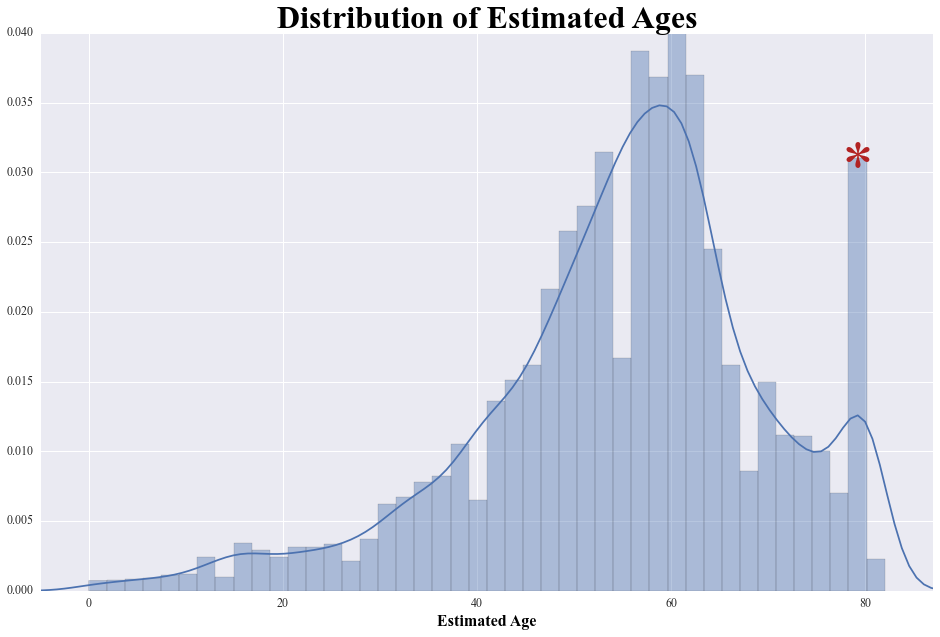

In [8]:
## PLOT OF AGE DISTIBUTION:

plt_format()

sns.distplot(claims.groupby('pat_id').est_age.mean())
plt.text(78, 0.029, "*", fontsize=64, color='firebrick')
plt.xlim(-5, 87)
plt.title('Distribution of Estimated Ages')
plt.xlabel('Estimated Age');

---

# Slide 6 Narrative:

#### Cursory Analysis of Age  
  
Here is a look at some descriptive statistics to get acquainted with the medical claims included in this data set.  
  
"Age" is not one of the columns provided by the raw claims or enrollment data.  This is understandable because it is not a static feature; this is unlike a person's year of birth which will never change.  When discussing health data, a enrollee's age could be different when they sign up for insurance, when they have a procedure, and/or when the data is submitted for analysis.   
  
To compensate for this, an estimated age is calculated for every patient.  The data submitted ends at December 31st, 2014.  
  
Given this fact, the year of birth can be subtracted from the year 2014 to get an approximated age.  This estimate may be off slightly, as the patient's year of birth is collected at insurance inception in 2011, 2012, 2013 or 2014.  
  
An alternate method for calculating estimated age would be to subtract the year of birth from each individual patient's first claim date.  This yields the most accurate age estimate, and is the chosen method.  This is still an approximation of the patient's actual age, for a few of reasons.  Obviously, with only year of birth known, they may or may not have already had their birthday for this year by insurance inception.  Secondly, this is calculated on the assumption that the first claim is in the same year as insurance inception; this could be verified, had the insurance enrollment date been pulled from the enrollment file.  Lastly, the age at inception is not their age any longer.  Perhaps insurance started in 2011 or 2013, now in 2016 their age is 4 or 2 years younger than actual.  Even given these shortcomings, this is the method used for estimating individual patients' ages.  
  
This is very useful information. The average estimated age for this population is nearly 55 years old, with a minimum age of 0 and a maximum of 82.  
  
One other observation is that the 'count' for est_age does not match the 1,788,544 rows included in the total claims file. In fact, there are 163 fewer counts than rows. Further analysis shows that two patients in the enrollment file do not contain year of birth information; this can be found directly from the claims data. Since this report focuses on age in relation to other factors, it is reasonable to drop the 2 patients without year of birth information, since this is only a small percentage of the 5,802 patient total.  
  
The two patients are removed, and following is a distribution plot of the estimated ages.  

---

--- 

# Slide 7:  

## Age ++

 - Further Descriptive Age Statistics:  
    - 12 = The Number of "82" Year Old Patients (0.001 %)  
    - 317 = The Number of Patients "80" Years Old or Older (0.02 %)  
    - 1931 = The Earliest Year of Birth for all Patients  
  
 - Health Insurance Portability and Accountability Act (HIPAA)  
    - Fewer people over the age of 85  
    - De-identify for privacy  
  
*Source: http://www.hhs.gov/hipaa/for-professionals/privacy/laws-regulations/*

In [9]:
## MORE DESCRIPTIVE STATISTICS:
print('Further Descriptive Age Statistics: \n')
print(len(claims[claims.est_age == claims.est_age.max()].drop_duplicates('pat_id')), '= The Number of "82" Year Old Patients')

print(round(len(claims[claims.est_age == claims.est_age.max()].drop_duplicates('pat_id')) / len(claims), 5) * 100, '%', 
      '= Percentage of Total Population that is Recorded as "82" \n')

print(len(claims[claims.est_age >= 80].drop_duplicates('pat_id')), '= The Number of Patients "80" Years Old or Older')

print(round(len(claims[claims.est_age >= 80].drop_duplicates('pat_id')) / len(claims), 4) * 100, '%', 
      '= Percentage of Total Population that is Recorded as 80 Years Old or Older \n')

print('{:.0f}'.format(claims.yob.min()), '= The Earliest Year of Birth for all Patients')
print(len(claims[claims.yob == claims.yob.min()].drop_duplicates('pat_id')), 
      '= The Number Patients with 1931 Recorded as their Year of Birth')
print(round(len(claims[claims.yob == claims.yob.min()].drop_duplicates('pat_id')) / len(claims), 5) * 100, '%', 
      '= Percentage of Total Population that is Recorded as Being Born in 1931')

Further Descriptive Age Statistics: 

12 = The Number of "82" Year Old Patients
0.001 % = Percentage of Total Population that is Recorded as "82" 

317 = The Number of Patients "80" Years Old or Older
0.02 % = Percentage of Total Population that is Recorded as 80 Years Old or Older 

1931 = The Earliest Year of Birth for all Patients
309 = The Number Patients with 1931 Recorded as their Year of Birth
0.017 % = Percentage of Total Population that is Recorded as Being Born in 1931


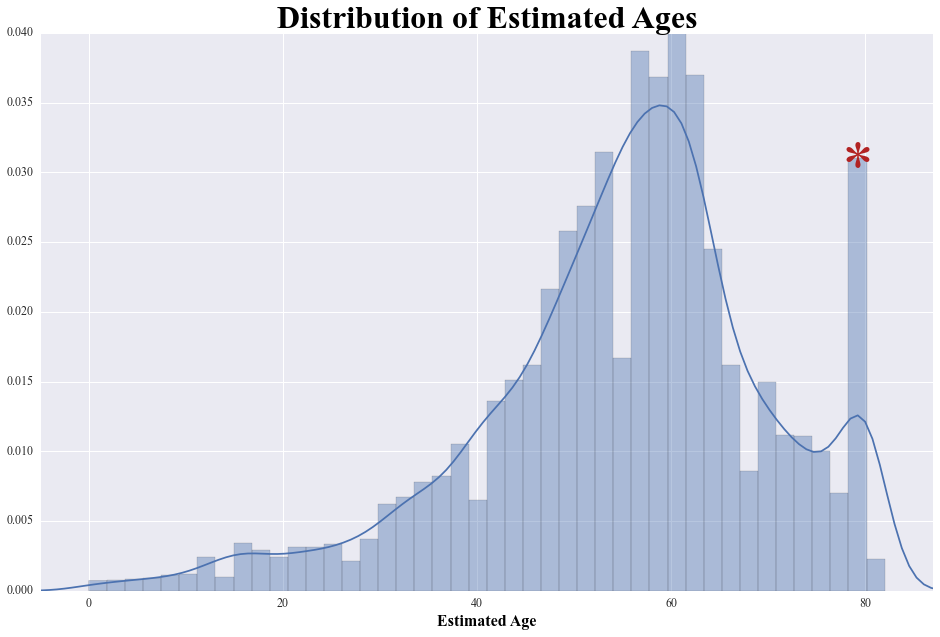

In [10]:
## PLOT OF AGE DISTIBUTION:

plt_format()

sns.distplot(claims.groupby('pat_id').est_age.mean())
plt.text(78, 0.029, "*", fontsize=64, color='firebrick')
plt.xlim(-5, 87)
plt.title('Distribution of Estimated Ages')
plt.xlabel('Estimated Age');

---

# Slide 7 Narrative:

#### The Most Elderly Patients

There is a high density of patients at age 80 or higher.  Perhaps there really are many geriatric patients in this data set.  However, this could be easily explained by the Health Insurance Portability and Accountability Act (HIPAA) de-identification standards.  "[A]ll ages over 89 and all elements of dates (including year) indicative of such age, except that such ages and elements may be aggregated into a single category of age 90 or older."  

*Source: http://www.hhs.gov/hipaa/for-professionals/privacy/laws-regulations/*

The rational for this is that there are fewer living people over the age of 85 or 90.  Given their advanced age plus other identification characteristics, it would be easier to deduce their identity than it would be for patients of younger ages just based on sheer number of people.  This is more specifically spelled out in the PharMetrics Legacy Health Plan Claims Data Dictionary, that accompanied the raw data files.  "[T]he year of birth for elderly patients (those over 85) is modified so that they all appear to be 85 years old in order to ensure de-identifiable patients."

*Source: "PharMetrics Legacy Health Plan Claims Data Dictionary" PDF, supplied in HW4_Files.*

What this ultimately means for the Claims data is that if a patient was age 85 or older at the time of insurance inception, they will be classified as age 85.  More specifically, the earliest year of birth recoded is 1931, depending on their actual year of birth at insurance inception, their estimated age could put them over the HIPAA threshold.  If the patients were born previous to 1931, they were assigned to this year of birth so that no patients are over the age of 85 for de-identification purposes.  All patients born prior to 1931 are labeled as having a birth year of 1931.  

---

---

# Slide 8:

## Patient Case 1: "Gertrude"  
  
 - Age: 82  
 - Gender: Female  
 - Region: East  
   
 - Number of Claims: 1,500  
 - Charges: $425,280  
 - Diagnoses: 97  
    - Hypertension  
    - End-stage renal disease  
    - Rheumatoid arthritis  
   
 - Insured: January 2013 through August 2014  
  
<img src='HW4_Files/Gertrude.gif'>

In [11]:
## OLDEST & MOST EXPENSIVE:

age82 = claims[claims.est_age == claims.est_age.max()]

age82_pts = pd.DataFrame(age82.groupby('pat_id')['charge'].sum()).reset_index()
print(age82_pts.pat_id.count(), '= Total Number of "82" Year Old Patients \n')

GertrudeID = age82_pts[age82_pts.charge == age82_pts.charge.max()].reset_index()
print(GertrudeID.pat_id[0], '= Patient ID for the Oldest & Most Expensive Patient')

12 = Total Number of "82" Year Old Patients 

mg39AAAAADMCJXKW = Patient ID for the Oldest & Most Expensive Patient


In [12]:
## GERTRUDE'S DSCRIPTIVE STATISTICS:

Gertrude = age82[age82.pat_id.isin(GertrudeID.pat_id)]

print(Gertrude.sex.unique(), "= Gertrude's Gender")
print("{:0.0f}".format(Gertrude.est_age.mean()), "= Gertrude's Age")
print(Gertrude.pat_region.unique(), "= Gertrude's Region")
print("{:0.0f}".format(Gertrude.nbr_clms.mean()), "= Number of Insurance Claims Processed for Gertrude")
print(Gertrude.ndc.nunique(), "= Number of Different Medications Filled for Gertrude")
print(Gertrude.from_dt.min(), "= Gertrude's First Insurance Claim Date")
print(Gertrude.to_dt.max(), "= Gertrude's Last Insurance Claim Date")
print('$', round(Gertrude.charge.sum(), 2), "= Sum of Gertrude's Medical Charges, 1/3/2013 - 8/24/2014")

diags = pd.concat([Gertrude.diag1_descrip, Gertrude.diag2_descrip, Gertrude.diag3_descrip, 
                   Gertrude.diag4_descrip], axis=0).unique()

print(len(diags), "= Number of Gertrude's Unique Diagnoses \n \n  Head of Diagnoses List:")
print(diags[1:11])

['F'] = Gertrude's Gender
82 = Gertrude's Age
['E'] = Gertrude's Region
1500 = Number of Insurance Claims Processed for Gertrude
50 = Number of Different Medications Filled for Gertrude
2013-01-03 00:00:00 = Gertrude's First Insurance Claim Date
2014-08-24 00:00:00 = Gertrude's Last Insurance Claim Date
$ 425280.43 = Sum of Gertrude's Medical Charges, 1/3/2013 - 8/24/2014
97 = Number of Gertrude's Unique Diagnoses 
 
  Head of Diagnoses List:
['2859 - ANEMIA NOS' '78841 - FREQUENCY URINARY'
 '5990 - INFECTION URINARY TRACT NOS' 'V1588 - HIST FALL'
 '4019 - HYPERTENSION ESSENTIAL NOS' '7962 - ABFND ELEVATED BP W/O HTN'
 '5854 - CHRONIC KIDNEY DIS STAGE IV (SEVERE'
 '5859 - CHRONIC KIDNEY DISEASE UNSPEC'
 '4011 - HYPERTENSION BENIGN ESSENTIAL'
 'V7283 - PREOPERATIVE EXAMINATION NEC']


---

# Slide 8 Narrative:

#### The Most Senior Patient: "Gertrude“
  
As already established, there are twelve patients recorded as being born in 1931, or being 82 years old. This group is further grouped by the sum of all insurance claim charges over the life of their insurance policy. This calculation is not a representation of the total population, because patients may have held insurance policies for differing time lengths. Yet, this is a valuable metric because it shows the bottom line cost impact for the insurance company. Lastly, the patient with the greatest sum of charges is extracted from the other 82 year olds by the patient identification key.  
  
Some descriptive statistics are calculated and she is assigned a fictitious name.  
  
Patient ID mg39AAAAADMCJXKW, referred to as "Gertrude," is an 82 years old female and lives in the East. There are fifteen hundred individual claims, totaling over four hundred thousand dollars, which accrued from January 2013 through August 2014. She has an extensive list of ninety-seven unique diagnoses, many which are chronic medical conditions including hypertension (high blood pressure), end-stage renal (kidney) disease, and rheumatoid arthritis.  

---

---

# Slide 9:  

## Dental Patients  

 - 1323 dental procedures performed  
  
 - 2055 claims include a dental diagnosis code  
  
 - Distribution of estimated age compared to that of the total claims population  

<img src='HW4_Files/dental.gif'>

In [13]:
## EXTAPOLATE CLAIMS WITH DENTAL DIAGNOSIS CODES (FROM ICD-9):

# (dD stands for Dental Diagnosis)
diagColumns = ['diag1', 'diag2', 'diag3', 'diag4']

dD_pt = pd.DataFrame()
dD_pt = pd.concat([claims[claims[diagColumns[0]].str.startswith('520', na=False)],  # ICD-9 520.xx
                   claims[claims[diagColumns[0]].str.startswith('521', na=False)],  # ICD-9 521.xx
                   claims[claims[diagColumns[0]].str.startswith('522', na=False)],  # ICD-9 522.xx
                   claims[claims[diagColumns[0]].str.startswith('523', na=False)],  # ICD-9 523.xx
                   claims[claims[diagColumns[0]].str.startswith('524', na=False)],  # ICD-9 524.xx
                   claims[claims[diagColumns[0]].str.startswith('525', na=False)],  # ICD-9 525.xx
                   claims[claims[diagColumns[0]].str.startswith('526', na=False)],  # ICD-9 526.xx
                   claims[claims[diagColumns[0]].str.startswith('527', na=False)],  # ICD-9 527.xx
                   claims[claims[diagColumns[0]].str.startswith('528', na=False)],  # ICD-9 528.xx
                   claims[claims[diagColumns[0]].str.startswith('529', na=False)],  # ICD-9 529.xx
                   
                   claims[claims[diagColumns[1]].str.startswith('520', na=False)],  # ICD-9 520.xx
                   claims[claims[diagColumns[1]].str.startswith('521', na=False)],  # ICD-9 521.xx
                   claims[claims[diagColumns[1]].str.startswith('522', na=False)],  # ICD-9 522.xx
                   claims[claims[diagColumns[1]].str.startswith('523', na=False)],  # ICD-9 523.xx
                   claims[claims[diagColumns[1]].str.startswith('524', na=False)],  # ICD-9 524.xx
                   claims[claims[diagColumns[1]].str.startswith('525', na=False)],  # ICD-9 525.xx
                   claims[claims[diagColumns[1]].str.startswith('526', na=False)],  # ICD-9 526.xx
                   claims[claims[diagColumns[1]].str.startswith('527', na=False)],  # ICD-9 527.xx
                   claims[claims[diagColumns[1]].str.startswith('528', na=False)],  # ICD-9 528.xx
                   claims[claims[diagColumns[1]].str.startswith('529', na=False)],  # ICD-9 529.xx
                   
                   claims[claims[diagColumns[2]].str.startswith('520', na=False)],  # ICD-9 520.xx
                   claims[claims[diagColumns[2]].str.startswith('521', na=False)],  # ICD-9 521.xx
                   claims[claims[diagColumns[2]].str.startswith('522', na=False)],  # ICD-9 522.xx
                   claims[claims[diagColumns[2]].str.startswith('523', na=False)],  # ICD-9 523.xx
                   claims[claims[diagColumns[2]].str.startswith('524', na=False)],  # ICD-9 524.xx
                   claims[claims[diagColumns[2]].str.startswith('525', na=False)],  # ICD-9 525.xx
                   claims[claims[diagColumns[2]].str.startswith('526', na=False)],  # ICD-9 526.xx
                   claims[claims[diagColumns[2]].str.startswith('527', na=False)],  # ICD-9 527.xx
                   claims[claims[diagColumns[2]].str.startswith('528', na=False)],  # ICD-9 528.xx
                   claims[claims[diagColumns[2]].str.startswith('529', na=False)],  # ICD-9 529.xx
                   
                   claims[claims[diagColumns[3]].str.startswith('520', na=False)],  # ICD-9 520.xx
                   claims[claims[diagColumns[3]].str.startswith('521', na=False)],  # ICD-9 521.xx
                   claims[claims[diagColumns[3]].str.startswith('522', na=False)],  # ICD-9 522.xx
                   claims[claims[diagColumns[3]].str.startswith('523', na=False)],  # ICD-9 523.xx
                   claims[claims[diagColumns[3]].str.startswith('524', na=False)],  # ICD-9 524.xx
                   claims[claims[diagColumns[3]].str.startswith('525', na=False)],  # ICD-9 525.xx
                   claims[claims[diagColumns[3]].str.startswith('526', na=False)],  # ICD-9 526.xx
                   claims[claims[diagColumns[3]].str.startswith('527', na=False)],  # ICD-9 527.xx
                   claims[claims[diagColumns[3]].str.startswith('528', na=False)],  # ICD-9 528.xx
                   claims[claims[diagColumns[3]].str.startswith('529', na=False)]])  # ICD-9 529.xx

print(len(dD_pt), '= The Number of Claims that Include a Dental Diagnosis')
print(len(dD_pt.drop_duplicates('pat_id')), '= Number of Patients for These Claims')

2055 = The Number of Claims that Include a Dental Diagnosis
358 = Number of Patients for These Claims


In [14]:
## EXTACT ALL PATIENTS WHO HAD A DENTAL PROCEDURE:

# Dental procedure codes start with 'D':
# (dP stands for Dental Procedure)
dP_pt = claims.loc[claims['proc_cde'].str.startswith('D', na=False)]  # Procedure was dental related

print(len(dP_pt), '= Number of Claims that Include a Dental Procedure')
print(len(dP_pt.drop_duplicates('pat_id')), '= Number of Patients for These Claims')

1323 = Number of Claims that Include a Dental Procedure
147 = Number of Patients for These Claims


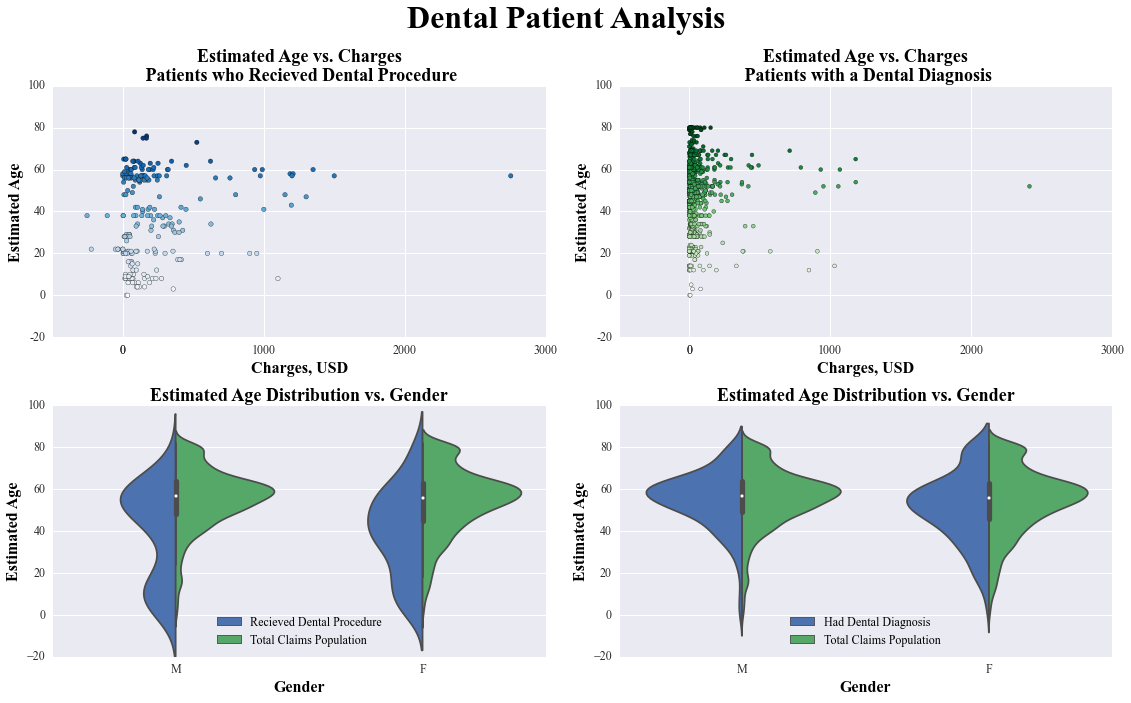

In [15]:
plt_format()

fig, ax = plt.subplots(2, 2)

col = ['pat_id', 'est_age', 'charge']
xlabels = [0, 0, 1000, 2000, 3000]
ylabels = [-20, 0, 20, 40, 60, 80, 100]

ax[0, 0].scatter(dP_pt[col].drop_duplicates('charge').charge, 
              dP_pt[col].drop_duplicates('charge').est_age, c=dP_pt[col].drop_duplicates('charge').est_age*10, cmap='Blues')
ax[0, 0].set_xticks(xlabels)
ax[0, 0].set_xticklabels(labels=xlabels)
ax[0, 0].set_yticks(ylabels)
ax[0, 0].set_yticklabels(labels=ylabels)
ax[0, 0].set_title('Estimated Age vs. Charges \n Patients who Recieved Dental Procedure', fontsize=18)
ax[0, 0].set_xlabel('Charges, USD')
ax[0, 0].set_ylabel('Estimated Age')

ax[0, 1].scatter(dD_pt[col].drop_duplicates('charge').charge/10, 
              dD_pt[col].drop_duplicates('charge').est_age, s=15, c=dD_pt[col].drop_duplicates('charge').est_age, cmap='Greens')
ax[0, 1].set_xticks(xlabels)
ax[0, 1].set_xticklabels(labels=xlabels)
ax[0, 1].set_yticks(ylabels)
ax[0, 1].set_yticklabels(labels=ylabels)
ax[0, 1].set_title('Estimated Age vs. Charges \n Patients with a Dental Diagnosis', fontsize=18)
ax[0, 1].set_xlabel('Charges, USD')
ax[0, 1].set_ylabel('Estimated Age')

col2 = ['pat_id', 'est_age', 'sex']
dPshort = dP_pt[col2].drop_duplicates('pat_id')
dPshort['type'] = 'Recieved Dental Procedure'
claimsShort = claims[col2].drop_duplicates('pat_id')
claimsShort['type'] = 'Total Claims Population'
dfTall = pd.concat([dPshort, claimsShort], axis=0)

sns.violinplot(x='sex', y='est_age', hue='type', data=dfTall, split=True, saturation=1, ax=ax[1, 0])
ax[1, 0].set_ylim(-20, 100)  
ax[1, 0].set_title('Estimated Age Distribution vs. Gender', fontsize=18)
ax[1, 0].set_xlabel('Gender')
ax[1, 0].set_ylabel('Estimated Age')
ax[1, 0].legend(loc=8, fontsize=12)


dDshort = dD_pt[col2].drop_duplicates('pat_id')
dDshort['type'] = 'Had Dental Diagnosis'
claimsShort = claims[col2].drop_duplicates('pat_id')
claimsShort['type'] = 'Total Claims Population'
dfTall = pd.concat([dDshort, claimsShort], axis=0)

sns.violinplot(x='sex', y='est_age', hue='type', data=dfTall, split=True, saturation=1, ax=ax[1, 1])
ax[1, 1].set_title('Estimated Age Distribution vs. Gender', fontsize=18)
ax[1, 1].set_xlabel('Gender')
ax[1, 1].set_ylabel('Estimated Age')
ax[1, 1].legend(loc=8, fontsize=12);

plt.suptitle('Dental Patient Analysis', fontsize=32, weight='heavy')
plt.tight_layout()
plt.subplots_adjust(top=0.87);

In [16]:
## CORRELATION COEFFICIENT, DENTAL DIAGNOSIS PATIENT:

dD_pt[['est_age', 'charge']].corr()

,est_age,charge
est_age,1.00000,-0.02114
charge,-0.02114,1.00000


In [17]:
## CORRELATION COEFFICIENT, DENTAL PROCEDURE PATIENT:

dP_pt[['est_age', 'charge']].corr()

,est_age,charge
est_age,1.000000,0.152029
charge,0.152029,1.000000


---

# Slide 9 Narrative:

#### Dental Patient Analysis
  
Often, people seek dental care in a traditional dental office setting, not a medical setting. There are times however, such as injury/trauma, acute infection, or lack of insurance where a person may go to a medical facility first for stabilized care. According to the American Dentistry Association, dental emergency visits totaled 2.2 million dollars in 2012, eighty-five percent of those patients did not have dental insurance (or government insurance only). These visits cost more than three times the amount of a routine dental visit, averaging $749 a visit and costing the United States health system 1.6 *billion* dollars per year.  
  
*Source: http://www.usatoday.com/story/nws/nation/2015/06/29/er-dental-visits/29492599*  
  
Therefore, the following figures may seem a bit low compared to the total claims data because these are those special cases of dental diagnoses and procedures within the medical care system.  
  
The ICD-9 codes for dental diagnoses all start with 520.xx-529.xx. First, all patients that received a dental diagnoses are extracted from the 4 diagnosis columns of the claims data.  
  
Also, the patients who received a dental procedure are extracted from the procedure code column.  
  
In the two estimated age versus charge plots, there is no linearly increasing trend between the variables.  This is confirmed by the very low respective correlation coefficients.  Also, when comparing the age distribution of both groups of dental patients, they are similar to or lower than the total claims population.  Since there is no obvious relationship, and the original claim is not negated.  

---

---

# Slide 10:

## Regional Breakdowns
  
 - Table of Patient Counts by Region:

In [18]:
## TABLE OF PATIENT COUNTS BY REGION:

print('Table of Patient Counts by Region:')
claims.groupby('pat_region').pat_id.nunique().reset_index()

Table of Patient Counts by Region:


,pat_region,pat_id
0,E,1624
1,MW,1580
2,S,1379
3,W,1217


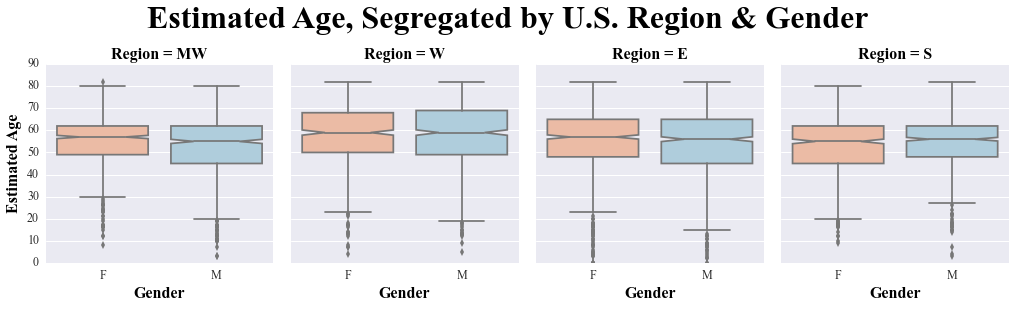

In [19]:
## PLOT OF COUNT DISTIBUTIONS:

plt_format()

a = sns.FacetGrid(claims.drop_duplicates('pat_id'), col="pat_region", size=4, aspect=0.9)
(a.map(sns.boxplot, "sex", "est_age", notch=True, palette='RdBu')
    .despine(left=True)
    .set_titles("Region = {col_name}")
    .set_xlabels('Gender')   
    .set_ylabels('Estimated Age'))

plt.suptitle('Estimated Age, Segregated by U.S. Region & Gender', y=1.08, fontsize=32, weight='bold');

---

# Slide 10 Narrative:
  
#### Regional Breakdowns
  
Prior to delving further into the data, one should look at the breakdown of patient demographics a bit more. Since this is insurance claim data, it lends a special-case look into those already covered by insurance and those already receiving care; this is very different from looking at general population demographics. There may be any numbers of barriers to healthcare. Age, gender and region are a just a few features to consider.  
  
For example, if an region has a high density of geriatric patients, there could be a shortage of appropriate healthcare providers meet the complex needs of this subpopulation at the times and in the settings they require. Similarly, caregivers could have trouble arranging transportation, communicating appointments, and adjusting to medication routines. Additionally, funds could be limited for patients on a fixed income.  
  
Gender inequalities are often not discussed in mainstream media, but they can result in access to care issues.  
  
“Three ways in which gender inequality in health care manifests itself in the United States:  
	- Gender inequality in health care presents itself as women have to pay higher insurance premiums than men.  
	- Another form of gender inequality in health care is the different rates at which men and women are insured; more women than men are insured in the United States.  
	- Gender inequalities in health care also revolve around different medicines are covered by insurance companies. For example, the contraceptive mandate demonstrates gender inequities in the different medicine that insurance companies are willing to cover for male and female patients.”  
    
*Source: Boundless. “Gender Inequality in Health Care.” Boundless Sociology. Boundless, 21 Jul. 2015. Retrieved 13 Apr. 2016*  
  
Detailed is a brief overview of these parameters including a breakdown of patient counts by region and count distributions by region, age and gender.  
  
The patients are not perfectly distributed amongst regions, age and gender. If more specific analysis is conducted on this on this data, it may be valuable to separate these into four separate sample populations to see how they compare to each other. That is beyond the scope of this report, and now is a closer look to see if age really does matter when it comes to other features.  

---

---

# Slide 11:

## Total Cost of a Patient

 - “In 2013, personal health care expenditures in the United States totaled 2.5 trillion dollars, a 3.8% increase from 2012. The per capita personal health care expenditure for the total U.S. population was $7,826 in 2013, up from 7,597 dollars in 2012.”  
  
*Source: [National Center for Health Statistics. Health, United States, 2014: With Special Feature on Adults](http://www.cdc.gov/nchs/data/hus/hus14.pdf#102)*   

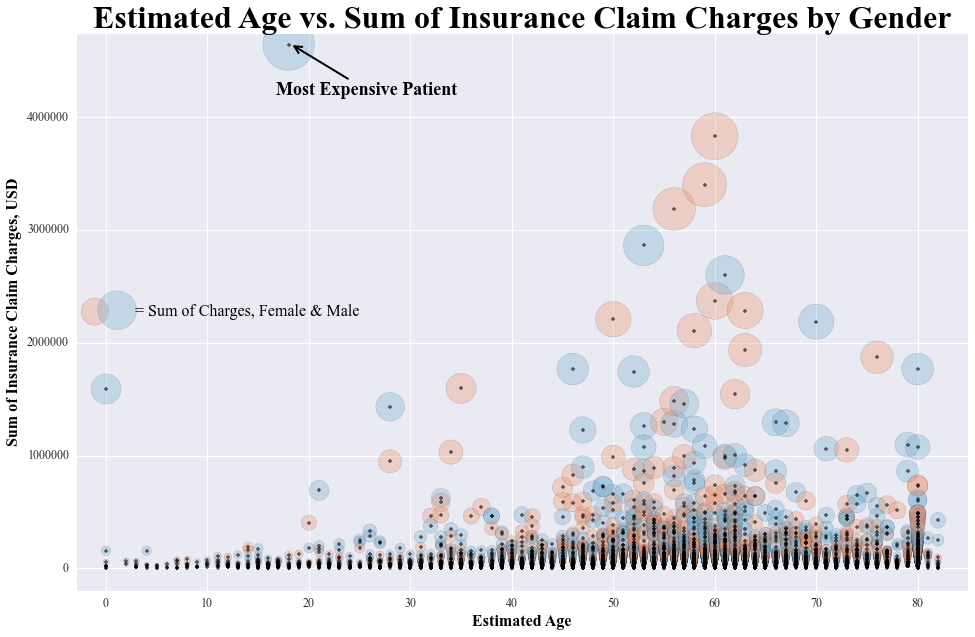

In [20]:
### AGE VS. COST:

plt_format()

b = pd.merge(claims.groupby('pat_id').est_age.mean().reset_index(), claims.groupby('pat_id').charge.sum().reset_index(), 
         how='inner', on='pat_id')
b = pd.merge(b, claims.groupby('pat_id').sex.unique().reset_index(), how='left', on='pat_id')

k = b[b.sex == 'M']
k['sex'] = 1
j = b[b.sex == 'F']
j['sex'] = 1
b = pd.concat([k, j], axis=0)

colors = ['#ef8a62', '#67a9cf']
plt.scatter(b.sort('est_age').est_age, b.sort('est_age').charge, s=b.sort('est_age').sex*b.sort('est_age').charge/1750, 
            c=colors, alpha=0.3, label='= Sum of Charges, Female & Male')
plt.plot(b.sort('est_age').est_age, b.sort('est_age').charge, '.', color='k', alpha=0.6)
plt.xlim(-3, 85)
plt.ylim(-200000, 4750000)

plt.title('Estimated Age vs. Sum of Insurance Claim Charges by Gender')
plt.xlabel('Estimated Age')
plt.ylabel('Sum of Insurance Claim Charges, USD')
plt.annotate('Most Expensive Patient', xy=(18.2, 4650000), xytext=(16.8, 4200000), fontsize=18, weight='heavy',
            arrowprops=dict(arrowstyle='->', linewidth=2, facecolor='black'))

plt.legend(loc=6, markerscale=0.75, scatterpoints=2);

In [21]:
## CORRELATION BETWEEN AGE & CHARGE:

print('Correlation Coefficients for Age vs. Charge:')
b[['est_age', 'charge']].corr()

Correlation Coefficients for Age vs. Charge:


,est_age,charge
est_age,1.000000,0.066523
charge,0.066523,1.000000


---

# Slide 11 Narrative:

#### Total Cost of a Patient
  
A discussion about healthcare is rarely complete without talking about cost as well. Popular culture may fixate on the cost of healthcare to the patient, but the counter discussion is cost of a patient to the insurance company, which could be further continued onto compensation for the provider. When analyzing insurance claim data, like the data set at hand, the claims may still be processing or waiting for reimbursement. However, under the traditional fee-for-service healthcare model, the charge amount listed on each claim is generally fixed, based on procedure, provider and/or place of service. Hence why there were no rows in the data set missing a value in the charge column.  
  
When talking about healthcare costs, the facts and figures are generally very large.  Concerns about the sustainability of healthcare costs over time are very real.   
  
“In 2013, personal health care expenditures in the United States totaled 2.5 trillion dollars, a 3.8% increase from 2012. The per capita personal health care expenditure for the total U.S. population was $7,826 in 2013, up from 7,597 dollars in 2012.”  
  
*Source: http://www.cdc.gov/nchs/data/hus/hus14.pdf#102*  
  
For the data set at hand, are cost and age directly associated with one another?  Following is a plot of the total sum of claim charges for each patient over age.  
  
At first glance, it may appear that cost is increasing with age. Yet, note the similarity in distribution to general estimated age distribution. It followed the same trend upwards until the mid-sixties, but then drops after the standard deviation of mean age. The correlation coefficient is calculated for more evidence.  
  
“The correlation coefficient will always be between -1 and 1. A correlation coefficient close to -1 implies that the two variables move in opposite directions. When one goes up, the other goes down. They are negatively correlated. A value close to 1 implies the opposite. If the value is zero, or close to zero, that means that the two variables do not share any particular correlation. There is no strong correlation relationship in one direction or the other.”  
  
*Source: http://classroom.synonym.com/correlation-coefficient-zero-mean-6470.html*  
  
Since the correlation coefficient for estimated age and charge is only 0.07, this implies that age and charge are not sharing a correlation, which does not negate the claim that age is just a number.  

---

---

# Slide 12:

## Patient Case 2: "Mason"
  
 - Age: 18  
 - Gender: Male  
 - Region: East  
  
 - Number of Claims: 391  
 - Charges: $4,645,797  
 - Diagnoses: 51  
    - Congestive heart failure  
    - Emphysema  
    - Alcohol Abuse  
  
 - Insured: December 2012 through August 2013  
 
<img src='HW4_Files/Mason.png'>

In [22]:
## LOCATE OUTLIER PATIENT ID:

k = pd.DataFrame(claims.groupby('pat_id').charge.sum() > 4000000)
idx = k[k['charge'] == True].index.tolist()
outlier = k.loc[idx].reset_index()

print(outlier.pat_id[0], '= Patient ID for the Most Expensive Patient')

q118AAAAAAAQSORD = Patient ID for the Most Expensive Patient


In [23]:
## DSCRIPTIVE STATISTICS FOR MASON:

Mason = claims[claims.pat_id.isin(outlier.pat_id)]

print(Mason.sex.unique(), "= Mason's Gender")
print("{:0.0f}".format(Mason.est_age.mean()), "= Mason's Age")
print(Mason.pat_region.unique(), "= Mason's Region")
print("{:0.0f}".format(len(Mason.nbr_clms)), "= Number of Insurance Claims Processed for Mason")
print(Mason.ndc.nunique(), "= Number of Different Medications Filled for Mason")
print(Mason.from_dt.min(), "= Mason's First Insurance Claim Date")
print(Mason.to_dt.max(), "= Mason's Last Insurance Claim Date")
print('$', round(Mason.charge.sum(), 2), "= Sum of Mason's Medical Charges, 12/16/2012 - 8/07/2013")

diags = pd.concat([Mason.diag1_descrip, Mason.diag2_descrip, Mason.diag3_descrip, 
                   Mason.diag4_descrip], axis=0).unique()

print(len(diags), "= Number of Mason's Unique Diagnoses \n \n  Head of Diagnoses List:")
print(diags[1:11])

['M'] = Mason's Gender
18 = Mason's Age
['E'] = Mason's Region
391 = Number of Insurance Claims Processed for Mason
37 = Number of Different Medications Filled for Mason
2012-12-16 00:00:00 = Mason's First Insurance Claim Date
2013-08-07 00:00:00 = Mason's Last Insurance Claim Date
$ 4645796.56 = Sum of Mason's Medical Charges, 12/16/2012 - 8/07/2013
51 = Number of Mason's Unique Diagnoses 
 
  Head of Diagnoses List:
['7452 - TETRALOGY OF FALLOT' '42732 - FLUTTER ATRIAL'
 '514 - CONGESTION/HYPOSTASIS PULMONARY' '4299 - DISEASE HEART NOS'
 '7853 - ABNORMAL HEART SOUNDS NEC' '4279 - DYSRHYTHMIA CARDIAC NOS' nan
 '4280 - FAILURE CONGESTIVE HEART' '71941 - PAIN IN JOINT SHOULDER'
 '4293 - CARDIOMEGALY']


---

# Slide 12 Narrative:

#### The Most Expensive Patient: "Mason"
  
The patient with the greatest sum of charges is extracted by the patient identification key.  
  
Some descriptive statistics are calculated and he is assigned a fictitious name.  
  
Patient ID q118AAAAAAAQSORD, referred to as "Mason," is an 18 years old male and lives in the East. He has had thirty-seven unique prescription claims and fifty-one diagnoses. There are nearly four hundred individual claims, totaling over four and a half million dollars. The amount is staggering by itself, but to know that these charges were accrued in less than 8 months is even more shocking. Some of Mason's chronic conditions include congestive heart failure, emphysema, and alcohol abuse.  

---

---

# Slide 13 

## Patient Case 2: “Mason”

<img src='HW4_Files/Mason.png'>

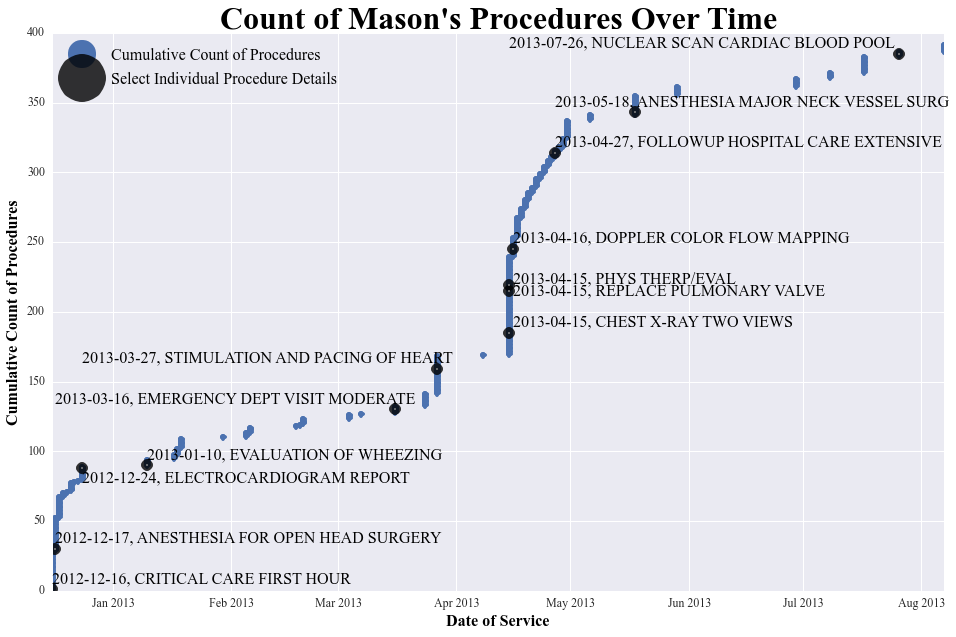

In [24]:
## TIMELINE PLOT FOR MASON:

plt_format()

s = Mason.sort('from_dt')
plt.plot(s.from_dt, s.nbr_clms.cumsum()/s.nbr_clms, 'o', label='Cumulative Count of Procedures')

x = [1458431, 1458482, 1458510, 1458520, 1458560, 1458573, 1458652, 1458605, 1458601, 1458677, 1458744, 1458784, 1458815]
t = s[s.index.isin(x)].from_dt
u = ((s[s.index.isin(x)].nbr_clms.cumsum()/s[s.index.isin(x)].nbr_clms + s.nbr_clms.cumsum()/s.nbr_clms).dropna() - 
     s[s.index.isin(x)].nbr_clms.cumsum()/s[s.index.isin(x)].nbr_clms)

plt.plot(t, u, 'o', markersize=12, color='black', alpha=0.8, label='Select Individual Procedure Details')
plt.plot(t, u, 'o', markersize=2, color='grey')

plt.text(t.iloc[0], u.iloc[0] +5, '2012-12-16, CRITICAL CARE FIRST HOUR')
plt.text(t.iloc[1], u.iloc[1] +5, '2012-12-17, ANESTHESIA FOR OPEN HEAD SURGERY')
plt.text(t.iloc[2], u.iloc[2] -10, '2012-12-24, ELECTROCARDIOGRAM REPORT')
plt.text(t.iloc[3], u.iloc[3] +5, '2013-01-10, EVALUATION OF WHEEZING')
plt.text(t.iloc[1], u.iloc[4] +5, '2013-03-16, EMERGENCY DEPT VISIT MODERATE')
plt.text(t.iloc[2], u.iloc[5] +5, '2013-03-27, STIMULATION AND PACING OF HEART')
plt.text(t.iloc[9], u.iloc[6] +2, '2013-04-15, PHYS THERP/EVAL')
plt.text(t.iloc[9], u.iloc[7] -3, '2013-04-15, REPLACE PULMONARY VALVE')
plt.text(t.iloc[9], u.iloc[8] +5, '2013-04-15, CHEST X-RAY TWO VIEWS')
plt.text(t.iloc[9], u.iloc[9] +5, '2013-04-16, DOPPLER COLOR FLOW MAPPING')
plt.text(t.iloc[10], u.iloc[10] +5, '2013-04-27, FOLLOWUP HOSPITAL CARE EXTENSIVE')
plt.text(t.iloc[10], u.iloc[11] +5, '2013-05-18, ANESTHESIA MAJOR NECK VESSEL SURG')
plt.text(t.iloc[8], u.iloc[12] +5, '2013-07-26, NUCLEAR SCAN CARDIAC BLOOD POOL')

plt.title("Count of Mason's Procedures Over Time")
plt.xlabel('Date of Service')
plt.ylabel('Cumulative Count of Procedures')

plt.legend(loc=2);

---

# Slide 13 Narrative:

#### The Most Expensive Patient: "Mason“ (continued)

Some specific procedures were extracted from Mason's data to include on a timeline plot of the eight months he filed claims with this insurance.

        INDEX      FROM DATE     PROCEDURE DSCRIPTION
     - 1458431	2012-12-16	CRITICAL CARE FIRST HOUR
     - 1458482	2012-12-17	ANESTHESIA FOR OPEN HEAD SURGERY
     - 1458510	2012-12-24	ELECTROCARDIOGRAM REPORT
     - 1458520	2013-01-10	EVALUATION OF WHEEZING
     - 1458560	2013-03-16	EMERGENCY DEPT VISIT MODERATE
     - 1458573	2013-03-27	STIMULATION AND PACING OF HEART
     - 1458652	2013-04-15	PHYS THERP/EVAL
     - 1458605	2013-04-15	REPLACE PULMONARY VALVE
     - 1458601	2013-04-15	CHEST X-RAY TWO VIEWS
     - 1458677	2013-04-16	DOPPLER COLOR FLOW MAPPING
     - 1458744	2013-04-27	FOLLOWUP HOSPITAL CARE EXTENSIVE
     - 1458784	2013-05-18	ANESTHESIA MAJOR NECK VESSEL SURG
     - 1458815	2013-07-26	NUCLEAR SCAN CARDIAC BLOOD POOL
     
Now there is a clearer picture as to the chain of events that led Mason's astronomical charges. He is an extremely complex cardiology patient who required multiple reparative surgeries on his heart during these eight months. He also spent multiple days in the hospital and went through a battery of tests day after day. Each of these procedures lent to Mason's sum of charges.

---

---

# Slide 14:

## Overall Charges by Month of the Year

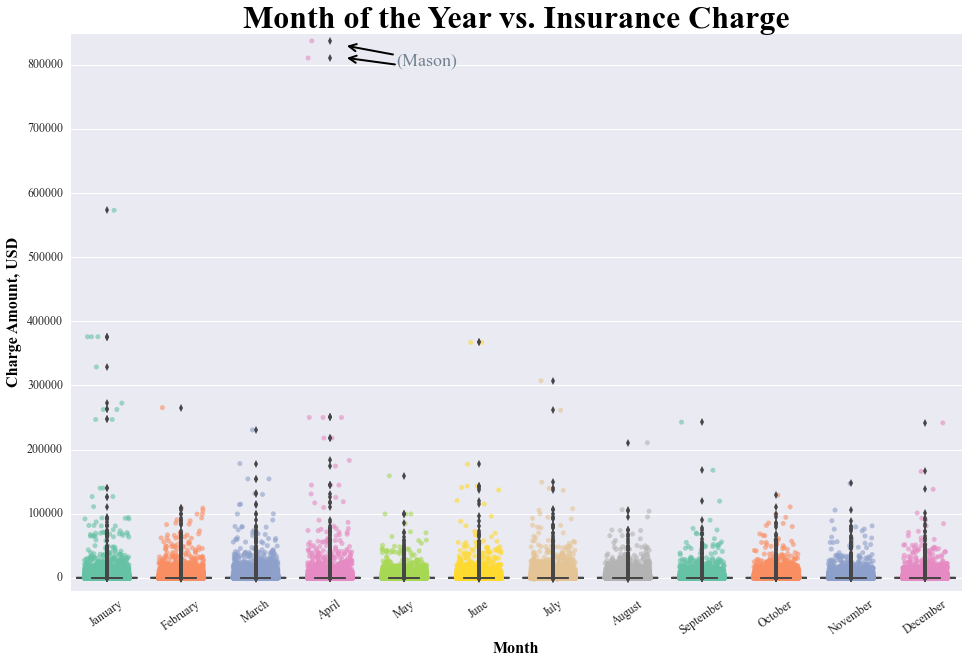

In [25]:
## PLOT OF OVERALL CHARGES BY MONTH:

plt_format()

# Create a 'month' column to the claims DataFrame:
claims['month'] = [i.month for i in claims.from_dt]

ax = sns.boxplot(claims.sort('from_dt').month, claims.sort('from_dt').charge, notch=True)

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.stripplot(claims.sort('from_dt').month, claims.sort('from_dt').charge, jitter=0.3, alpha=0.6, palette='Set2')
plt.annotate('(Mason)', xy=(3.2, 830000), xytext=(3.9, 800000), fontsize=18, color='slategray',
            arrowprops=dict(arrowstyle='->', linewidth=2, facecolor='slategray'))
plt.annotate('', xy=(3.2, 811000), xytext=(3.9, 800000), fontsize=18,
            arrowprops=dict(arrowstyle='->', linewidth=2, facecolor='slategray'))

plt.ylim(-20000, 850000)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                    'November', 'December'], rotation=35)
plt.title('Month of the Year vs. Insurance Charge')
plt.xlabel('Month')
plt.ylabel('Charge Amount, USD');

plt.savefig('HW4_Files/MonthCharge.jpg')

---

# Slide 14 Narrative:

#### Overall Charges by Month of the Year  
  
There are many potential ways to break apart and analyze the data from the "charge" column. One way is to separate and look at the data simply by each month of a calendar year.  
  
Mason is an obvious outlier, once again. There are few charges over twenty thousand dollars except in the months of January, April, June and July.  

---

---

# Slide 15:

## Overall Charges by Month of the Year  

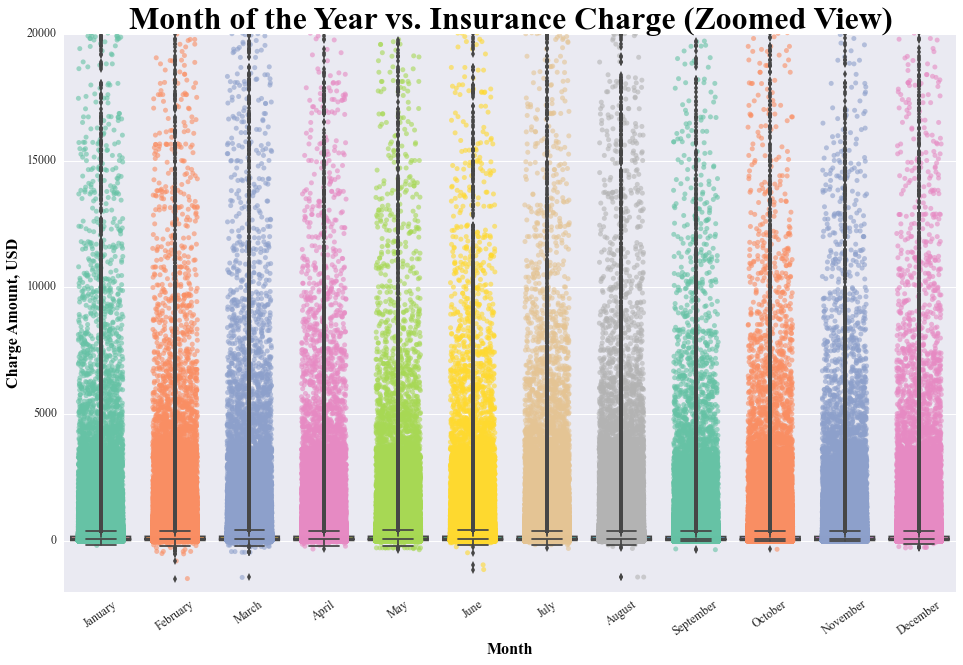

In [26]:
## ZOOMED VIEW OF OVERALL CHARGES BY MONTH:

plt_format()

ax = sns.boxplot(claims.sort('from_dt').month, claims.sort('from_dt').charge, notch=True)

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.stripplot(claims.sort('from_dt').month, claims.sort('from_dt').charge, jitter=0.3, alpha=0.6, palette='Set2')

plt.ylim(-2000, 20000)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                    'November', 'December'], rotation=35)
plt.title('Month of the Year vs. Insurance Charge (Zoomed View)')
plt.xlabel('Month')
plt.ylabel('Charge Amount, USD');

In [27]:
## CORRELATION BETWEEN MONTH & CHARGE:

print('Correlation Coefficients for Month of the Year vs. Charge:')
claims[['month', 'charge']].corr()

Correlation Coefficients for Month of the Year vs. Charge:


,month,charge
month,1.000000,-0.006765
charge,-0.006765,1.000000


---

# Slide 15 Narrative:

#### Overall Charges by Month of the Year (continued)  
  
A zoomed view of this plot, limiting the range to a maximum of twenty thousand dollars, is provided.  
  
Besides a few outliers, the claim charges do not show drastic variation from one month of the year to another. Since the charges are based on procedures, it is of interest to look at how many procedures the patients are receiving, particularly in relation to age. Below is a correlation coefficient calculation for further verification.  
  
The correlation coefficient is close to zero, meaning that month of the year and charges do not have a particular correlation between them.  

The correlation coefficient is close to zero, meaning that month of the year and charges do not have a particular correlation between them.

---

---

# Slide 16:

## Unique Procedure Counts per Patient

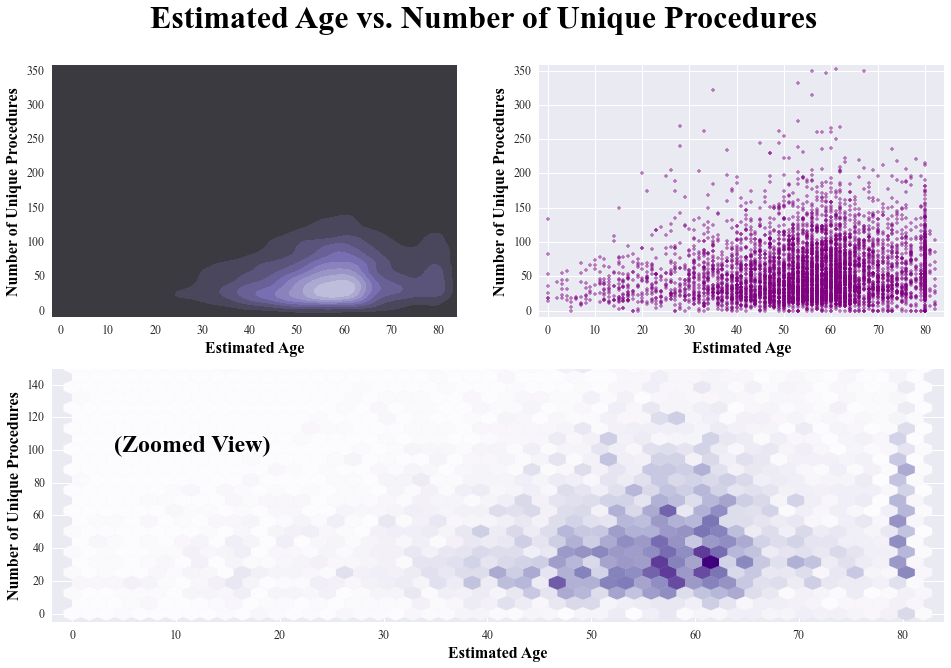

In [28]:
## PLOT OF OVERALL PROCEDURE COUNTS PER PATIENT:

plt_format()

c = pd.merge(claims.groupby('pat_id').est_age.mean().reset_index(), claims.groupby('pat_id').proc_cde.nunique().reset_index(), 
         how='inner', on='pat_id')

fig = plt.figure()
gs = mpl.gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.kdeplot(c.est_age, c.proc_cde, shade=True,  cmap='Purples_d', ax=ax1)
ax1.set_xlim(-2, 84)
ax1.set_ylim(-10, 360)
ax1.set_xlabel('Estimated Age')
ax1.set_ylabel('Number of Unique Procedures')

ax2.plot(c.est_age, c.proc_cde, '.', color='purple', alpha=0.5)
ax2.set_xlim(-2, 84)
ax2.set_ylim(-10, 360)
ax2.set_xlabel('Estimated Age')
ax2.set_ylabel('Number of Unique Procedures')

ax3.hexbin(c.est_age, c.proc_cde, gridsize=50, cmap='Purples')
ax3.set_xlim(-2, 84)
ax3.set_ylim(-5, 150)
ax3.set_xlabel('Estimated Age')
ax3.set_ylabel('Number of Unique Procedures')
ax3.text(4, 100, '(Zoomed View)', fontsize=24, weight='bold')

plt.suptitle('Estimated Age vs. Number of Unique Procedures', fontsize=32, weight='heavy');

In [29]:
## CORRELATION BETWEEN AGE & PROCEDURE COUNTS:

print('Correlation Coefficients for Age vs. Procedure Counts:')
c[['est_age', 'proc_cde']].corr()

Correlation Coefficients for Age vs. Procedure Counts:


,est_age,proc_cde
est_age,1.000000,0.126301
proc_cde,0.126301,1.000000


---

# Slide 16 Narrative:

#### Counting the Number of Procedures that Patients Receive  

Procedure costs can vary significantly.  Therefore, it is important to look at the counts of procedures to see if procedure counts increase with age.

> **How Many Procedures Did Patients Receive Per Hospital Stay?**  
> - [. . .] Approximately 20 percent of hospitalizations involved 3 or more procedures.  
> - Procedures can be classified into 1 of 4 broad categories: minor diagnostic, minor therapeutic, major diagnostic, and major therapeutic. About 30 percent of hospital stays involved at least 1 major therapeutic procedure, while another 24 percent included minor therapeutic and diagnostic procedures.  
>  
> **What Were the Most Common Medical and Surgical Procedures for Various Age Groups?**  
> - In 2003, blood transfusions were among the top 10 procedures performed in all age groups, occurring in 77 percent more hospitalizations than in 1997. During this 7-year period, the number of transfusions for patients 45 to 64 years of age nearly doubled. The largest increase in the percentage of hospital stays involving a blood transfusion—nearly 70 percent—occurred for individuals age 65 and older. This increase in transfusions was accompanied by a 78-percent increase in the number of hospitalizations for anemia in 2003.  
> - Similar to the pattern in 1997, respiratory intubation was also among the top 10 procedures for all age groups. But unlike blood transfusions, the number of intubations decreased over the 7-year period for each age group.  
> - The 2 most common procedures for children under 1 year of age remained the same in 2003: circumcisions and vaccinations. Circumcisions continued to be performed on 1.2 million infant boys. Vaccinations continued to be the second most common procedure with a 40-percent increase in the percentage of inpatient vaccinations performed in young children across the 7-year period. The vast majority of these consisted of hepatitis B vaccines given to infants at birth.  
> - Similar to 1997, appendectomy was the most common procedure for children ages 1-17; it was performed in 5 percent of all hospitalizations in this age group. Other top procedures included diagnostic spinal taps, blood transfusions, cancer chemotherapy, and respiratory intubation.  
> - When obstetrical procedures were included, 44 percent of procedures performed on all patients 18 to 44 years of age were related to pregnancy and childbirth (data not shown).  
> - After pregnancy- and childbirth-related procedures were excluded, hysterectomy emerged as the most common procedure and accounted for 5 percent of hospitalizations for patients ages 18-44, while oophorectomy accounted for another 3 percent. The percentage of cholecystectomies performed as inpatient procedures for this age group remained about the same, despite the move toward laparoscopic cholecystectomies that are often performed in outpatient settings.  
> - Three of the top 10 procedures for individuals ages 45-64 involved the cardiovascular system: diagnostic cardiac catheterization, PTCA, and echocardiogram.  
> - In 2003, several heart-related procedures continued to be among the most frequent procedures performed on patients ages 65-79: diagnostic cardiac catheterization, PTCA, echocardiogram, and CABG.  
> - For individuals 80 years of age and older, 3 diagnostic procedures were among the top 10 most frequent procedures, comprising 12 percent of procedures in this age group: upper GI endoscopy, diagnostic cardiac catheterization, and echocardiogram. Cardiovascular procedures were performed in another 9 percent of hospitalizations.  

*Source: [Procedures in U.S. Hospitals, 2003. Agency for Healthcare Research and Quality; U.S. Department of Health and Human Services.](http://archive.ahrq.gov/data/hcup/factbk7/factbk7b.htm)*
  
Following is a plot of the unique procedure counts per patient by age.  
  
This is a rendering of the data in three different ways. The top left is a kernel density estimation plot, showing where the concentration of data points are located. The top right shows all data points for number of procedures vs. age. This allows for easier viewing of outlier data points. It also shows that although the densest area is in the fifty to sixty-year range, there are still many moderately high points (meaning two hundred or more procedures) amongst some of the younger ages. Lastly, the hexbin plot also shows density but is zoomed into the zero to one hundred and forty procedure range for more clarity. It is easily seen that by the mid-sixties both density and number of procedures drops compared to the previous decade.  
  
A correlation coefficient matrix is calculated below for further verification.  
  
The correlation coefficient is 0.13 which is a bit higher than other correlation coefficients calculated thus far. Yet, it is still close to zero, and there is still no evidence to say that age is more than a number.  
  
Next is an investigation into one of the patients who had the most procedures.  

---

---

# Slide 17:

## Patient Case 3: "Sheryl"  
  
 - Age: 67  
 - Gender: Female  
 - Region: West  
  
 - Number of Claims: 2,950  
 - Charges: $1,286,137  
 - Diagnoses: 150  
    - Multiple myeloma  
    - Renal failure  
    - Malignant neoplasm of the breast  
    - Leukemua  
  
 - Insured: July 2011 through August 2014  
 
<img src='HW4_Files/Sheryl.gif'>

In [30]:
## FINDING THE PATIENTS WITH THE HIGHEST UNIQUE PROCEDURE COUNTS:

n_proc = claims.groupby('pat_id').proc_cde.nunique().reset_index()
high_proc = n_proc[n_proc.proc_cde >= 350].reset_index()

print(high_proc.pat_id, '= Patient IDs for the Patients with the Most Procedures')

0    7701AAAAAAASTWWU
1    9612AAAAAADNPJZA
2    9672AAAAAKXEGVRO
Name: pat_id, dtype: object = Patient IDs for the Patients with the Most Procedures


In [31]:
## DESCRIPTIVE STATISTICS FOR SHERYL:

Sheryl = claims[claims.pat_id.isin(high_proc.iloc[0])]

print(Sheryl.sex.unique(), "= Sheryl's Gender")
print("{:0.0f}".format(Sheryl.est_age.mean()), "= Sheryl's Age")
print(Sheryl.pat_region.unique(), "= Sheryl's Region")
print("{:0.0f}".format(Sheryl.nbr_clms.mean()), "= Number of Insurance Claims Processed for Sheryl")
print(Sheryl.gen_nm.nunique(), "= Number of Different Medications Filled for Sheryl")
print(Sheryl.from_dt.min(), "= Sheryl's First Insurance Claim Date")
print(Sheryl.to_dt.max(), "= Sheryl's Last Insurance Claim Date")
print('$', round(Sheryl.charge.sum(), 2), "= Sum of Sheryl's Medical Charges, 07/20/2011 - 8/29/2014")

diags = pd.concat([Sheryl.diag1_descrip, Sheryl.diag2_descrip, Sheryl.diag3_descrip, 
                   Sheryl.diag4_descrip], axis=0).unique()

print(len(diags), "= Number of Sheryl's Unique Diagnoses \n \n  Head of Diagnoses List:")
print(diags[1:11])

['F'] = Sheryl's Gender
67 = Sheryl's Age
['W'] = Sheryl's Region
2950 = Number of Insurance Claims Processed for Sheryl
40 = Number of Different Medications Filled for Sheryl
2011-07-20 00:00:00 = Sheryl's First Insurance Claim Date
2014-08-29 00:00:00 = Sheryl's Last Insurance Claim Date
$ 1286136.73 = Sum of Sheryl's Medical Charges, 07/20/2011 - 8/29/2014
150 = Number of Sheryl's Unique Diagnoses 
 
  Head of Diagnoses List:
[nan '78900 - PAIN ABDOMINAL SITE NOS' '37700 - PAPILLEDEMA NOS'
 '7231 - CERVICALGIA' '4739 - SINUSITIS CHRONIC NOS'
 '4779 - RHINITIS ALLERGIC NOS' '3089 - REACTION ACUTE STRESS NOS'
 '78652 - PAINFUL RESPIRATION' '3829 - OTITIS MEDIA NOS'
 '2724 - HYPERLIPIDEMIA NEC/NOS']


---

# Slide 17 Narrative:

#### The Patient with the Maximum Number of Procedures: "Sheryl"
  
There are three patients who received three hundred and fifty unique procedures or more. The top patient with the greatest sum of procedures is extracted by patient identification key.  
  
Some descriptive statistics are calculated and she is assigned a fictitious name.  
  
Patient ID 7701AAAAAAASTWWU, referred to as "Sheryl," is an 67 years old female and lives in the West. She has had forty unique prescription claims and a hundred and fifty diagnoses. There are nearly three thousand individual claims, totaling over a million dollars. The insurance claims paint a three year medical history landscape for Sheryl. Some of Sheryl's chronic conditions include multiple myeloma (cancer), renal (kidney) failure, malignant neoplasm (cancer) of the breast, and leukemia.  

---

---

# Slide 18:

## Patient Case 3: "Sheryl"
  
<img src='HW4_Files/Sheryl1.gif'>

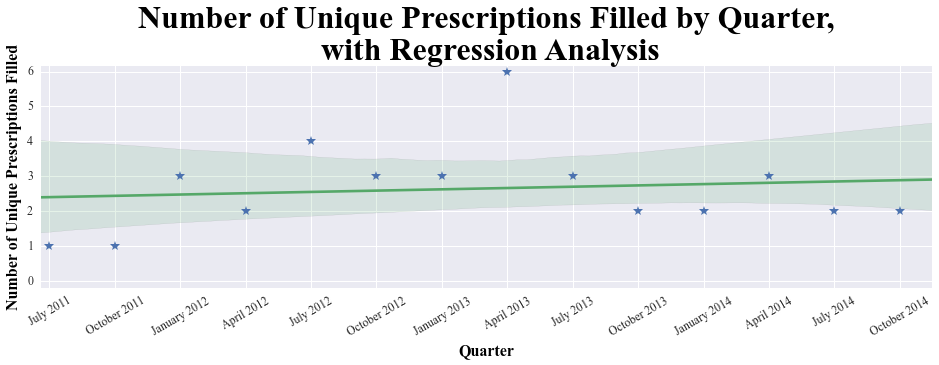

In [32]:
## PLOT OF UNIQUE PRESCIPTIONS FOR SHERYL, BY QUARTER:

plt_format()

plt.rcParams['figure.figsize'] = (16, 4)
fig, ax = plt.subplots(1, 1)

plt.plot(Sheryl.groupby('from_dt').ndc.count().resample('3M', how=pd.Series.nunique).dropna(), '*', markersize=10)
ax.set_xticks(range(len(Sheryl.groupby('from_dt').ndc.count().resample('3M', how=pd.Series.nunique).dropna())))
ax.set_xticklabels(
    Sheryl.groupby('from_dt').ndc.count().resample('3M', how=pd.Series.nunique).dropna().reset_index(
    ).from_dt.apply(lambda x: x.strftime('%B %Y')), 
    rotation=30)
plt.xlim(-0.15, 13.5)
plt.ylim(-0.2, 6.2)

sns.regplot(pd.Series(range(len(Sheryl.groupby('from_dt').ndc.count().resample('3M', how=pd.Series.nunique).dropna()))), 
           Sheryl.groupby('from_dt').ndc.count().resample('3M', how=pd.Series.nunique))

plt.title('Number of Unique Prescriptions Filled by Quarter, \n with Regression Analysis')
plt.xlabel('Quarter')
plt.ylabel('Number of Unique Prescriptions Filled');

In [33]:
## CORRELATION BETWEEN AGE AND NUMBER OF PRESCRIPTIONS:

print('Correlation Coefficients for Age vs. Number of Prescriptions:')
claims[['est_age', 'ndc']].corr()

Correlation Coefficients for Age vs. Number of Prescriptions:


,est_age,ndc
est_age,1.000000,0.003618
ndc,0.003618,1.000000


---

# Slide 18 Narrative:

#### The Patient with the Maximum Number of Procedures: "Sheryl“ (continued)  
  
A patient this medically complex usually is on many medications. Here is a view of the number of unique prescriptions Sheryl had claims for, broken up into three month quarters.  
  
Sheryl's number of prescriptions have fluctuated over the years, but they are not increasing over time. The correlation coefficient is calculated below for age versus prescriptions. Although this is not specific to Sheryl's story, it does not negate the findings.  

---

---

# Slide 19:

## Patient Case 3: "Sheryl“
  
<img src='HW4_Files/Sheryl2.png'>

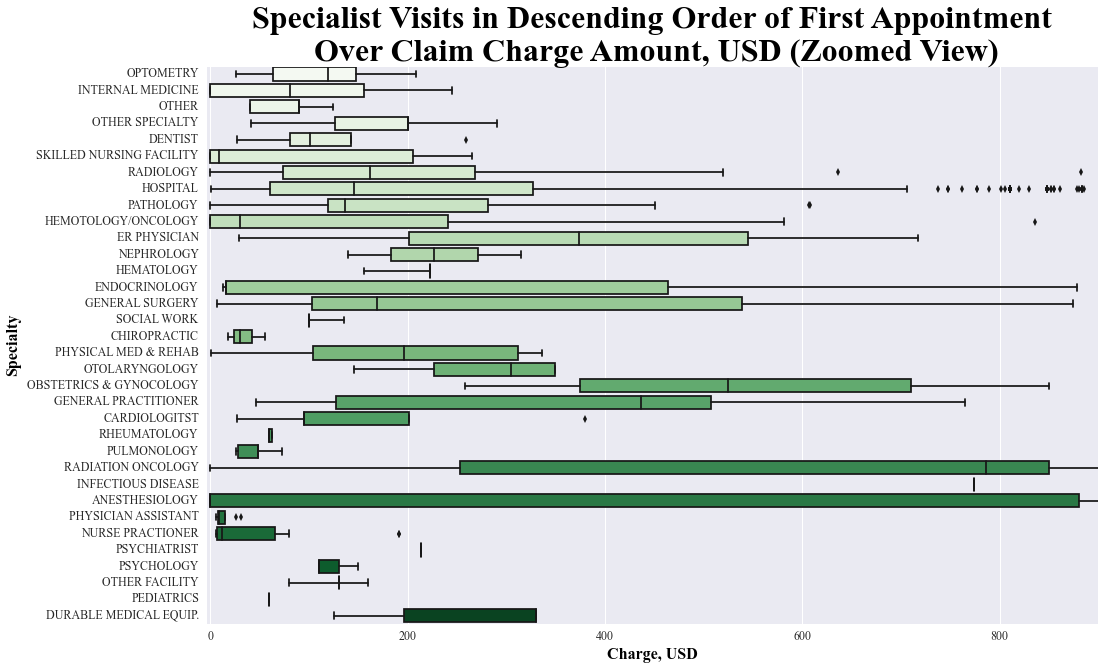

In [34]:
## PLOT OF SPECIALIST VISIT COSTS:

plt_format()

fig, ax = plt.subplots(1, 1)
sns.boxplot(Sheryl.sort('from_dt').charge, Sheryl.sort('from_dt').specialist, palette='Greens',  orient='h')
ax.set_yticklabels(['OPTOMETRY', 'INTERNAL MEDICINE', 'OTHER', 'OTHER SPECIALTY', 'DENTIST', 'SKILLED NURSING FACILITY', 
                       'RADIOLOGY', 'HOSPITAL', 'PATHOLOGY', 'HEMOTOLOGY/ONCOLOGY', 'ER PHYSICIAN', 'NEPHROLOGY', 'HEMATOLOGY', 
                       'ENDOCRINOLOGY', 'GENERAL SURGERY', 'SOCIAL WORK', 'CHIROPRACTIC', 'PHYSICAL MED & REHAB', 'OTOLARYNGOLOGY', 
                       'OBSTETRICS & GYNOCOLOGY', 'GENERAL PRACTITIONER', 'CARDIOLOGITST', 'RHEUMATOLOGY', 'PULMONOLOGY', 
                       'RADIATION ONCOLOGY', 'INFECTIOUS DISEASE', 'ANESTHESIOLOGY', 'PHYSICIAN ASSISTANT', 'NURSE PRACTIONER', 
                       'PSYCHIATRIST', 'PSYCHOLOGY', 'OTHER FACILITY', 'PEDIATRICS', 'DURABLE MEDICAL EQUIP.'])
plt.xlim(-5, 900)
plt.title('Specialist Visits in Descending Order of First Appointment \n Over Claim Charge Amount, USD (Zoomed View)')
plt.xlabel('Charge, USD')
plt.ylabel('Specialty');

---

# Slide 19 Narrative:

#### The Patient with the Maximum Number of Procedures: "Sheryl“ (continued)   
   
Next is a view of charges for visits to specialists. They are listed in descending order from the first specialist she saw, but the distributions are for all visits to each specialty type.  
  
This is a zoomed view, as some of the distributions for charges were upwards of seventy thousand dollars, and the differences between specialists was hard to discern in the full view. With so many specialists caring for Sheryl, it is easier to see how her procedure count crept up so high over the years.  
  
If total charge and procedure counts do not directly increase as age increases, perhaps it is useful to see the how the total number of claims relate to age.  

---

---

# Slide 20:

## Variations in Insurance Claim Totals

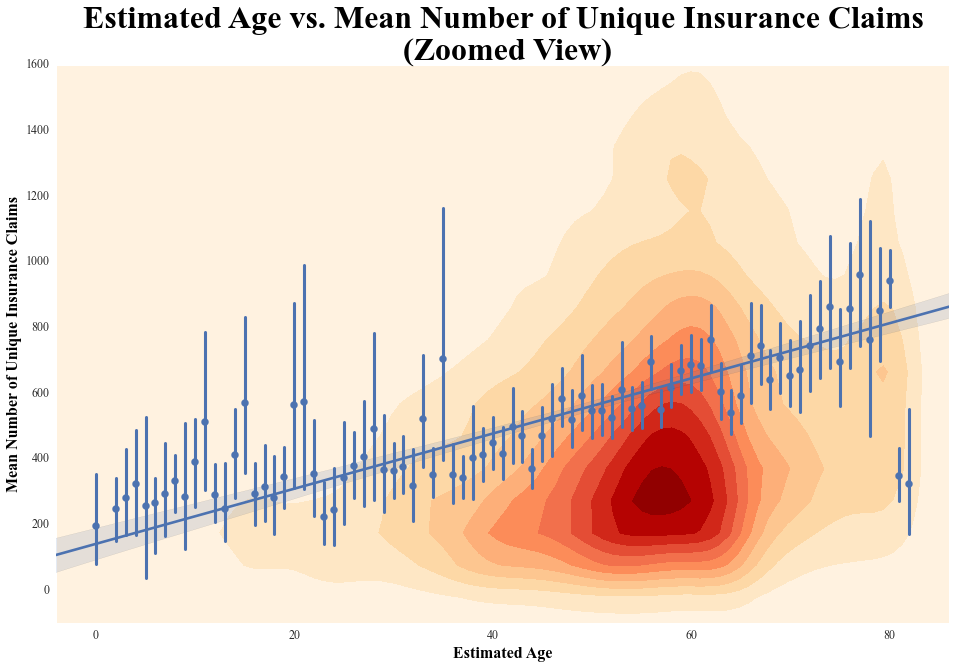

In [35]:
## ZOOMED VIEW THE MEAN INSURANCE CLAIM COUNTS:

plt_format()

d = pd.merge(claims.groupby('pat_id').est_age.mean().reset_index(), claims.groupby('pat_id').nbr_clms.mean().reset_index(), 
         how='inner', on='pat_id')
         
ax = sns.regplot(d.est_age, d.nbr_clms, x_estimator=np.mean)

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.kdeplot(d.est_age, d.nbr_clms, shade=True, cmap='OrRd')

plt.xlim(-4, 86)
plt.ylim(-100, 1600)
plt.title('Estimated Age vs. Mean Number of Unique Insurance Claims \n (Zoomed View)')
plt.xlabel('Estimated Age')
plt.ylabel('Mean Number of Unique Insurance Claims');

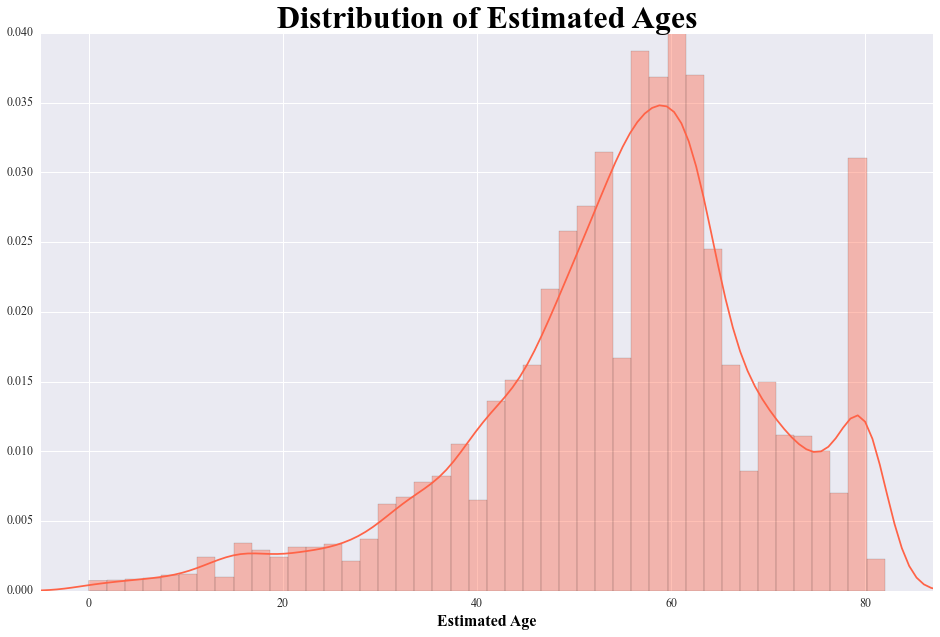

In [36]:
## REVIEW/REPEAT OF ESTIMATED AGE DISTIBUTION PLOT:

plt_format()

sns.distplot(claims.groupby('pat_id').est_age.mean(), color='Tomato')
plt.xlim(-5, 87)
plt.title('Distribution of Estimated Ages')
plt.xlabel('Estimated Age');

Sketch version:

<img src='HW4_Files/DistEstAgeSketch.jpg'>

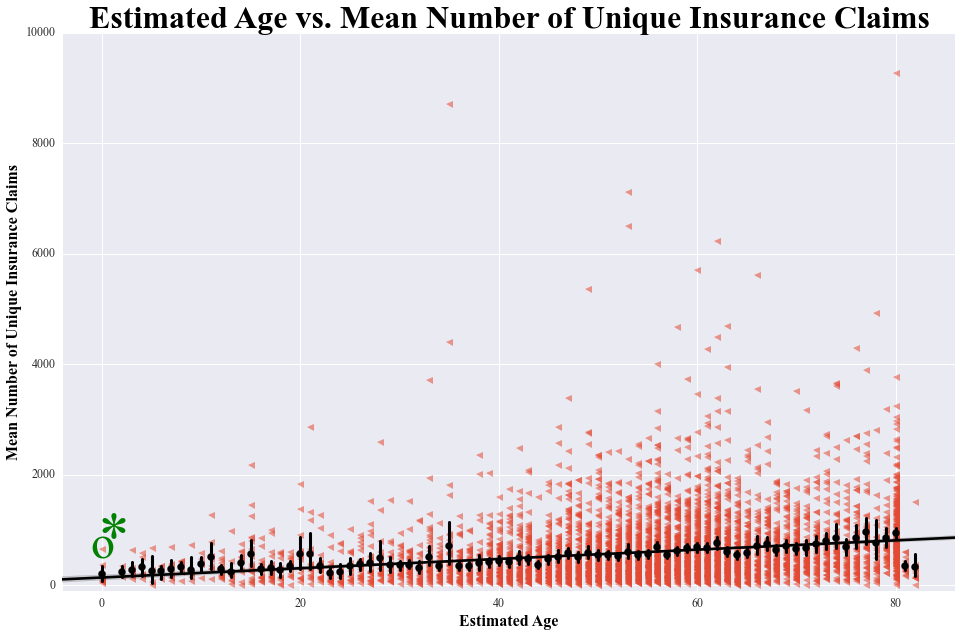

In [37]:
## PLOT OF AGE VS. MEAN NUMBER OF INSURANCE CLAIMS:

plt_format()

ax = sns.regplot(d.est_age, d.nbr_clms, x_estimator=np.mean, color='black')

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.plot(d.est_age, d.nbr_clms, "<", linewidth=0.1, alpha=0.55, color='#e34a33')
plt.text(-1, 500, "o", fontsize=48, color='green')
plt.text(0, 500, "*", fontsize=64, color='green')

plt.xlim(-4, 86)
plt.ylim(-100, 10000)
plt.title('Estimated Age vs. Mean Number of Unique Insurance Claims')
plt.xlabel('Estimated Age')
plt.ylabel('Mean Number of Unique Insurance Claims');

In [38]:
## CORRELATION BETWEEN AGE & NUMBER OF INSURANCE CLAIMS:

print('Correlation Coefficients for Age vs. Number of Insurance Claims:')
d[['est_age', 'nbr_clms']].corr()

Correlation Coefficients for Age vs. Number of Insurance Claims:


,est_age,nbr_clms
est_age,1.000000,0.216203
nbr_clms,0.216203,1.000000


---

# Slide 20 Narrative:

#### Variations in Individual Insurance Claim Totals  
  
As seen above, a zoomed view of a plot can often be helpful for seeing the subtle differences in data distributions that are lost when seeing the entire data set. There can be drawbacks as well. Take for example the two versions of the same plot below. First is the zoomed version of the mean count of individual insurance claims.  
  
At first glance, it looks like the regression line is steadily increasing over time. However, both the density and mean estimations drop towards the end of the plot. As a reminder, here is the distribution of estimated ages, which follows the same pattern.  
  
Lastly, here is the full view of the data and regression line.  
  
The full view of the data and regression line do not show a drastic increase, and its easiest to see that the youngest and oldest patients have approximately the same number of unique claims.  
  
The correlation coefficient below of 0.22 is creeping higher from zero, but is still less than the 0.30 threshold of a weak linear relationship. Therefore, there is still no reason to change the view that age is a mere number.  

---

---

# Slide 21:

## Patient Case 4: "Sierra"  
  
 - Age: 0  
 - Gender: Female  
 - Region: East  
  
 - Number of Claims: 656  
 - Charges: $1,590,351  
 - Diagnoses: 119  
    - Preterm birth  
    - Cleft lip  
    - Congenital heart defects  
  
 - Insured: July 2011 through August 2013  

<img src='HW4_Files/Sierra.png'>

In [39]:
## YOUNGEST PATIENTS:

l = pd.DataFrame(claims.groupby('pat_id').est_age.mean() == claims.groupby('pat_id').est_age.mean().min())
idx = l[l['est_age'] == True].index.tolist()
youngsters = l.loc[idx].reset_index()

print(youngsters.pat_id, '= The Patient IDs for the Eight Babies Less Than a Year Old')

0    q163AAAAABFDLGXL
1    q168AAAAABNUQXNH
2    q168AAAAABNUXCSQ
3    q170AAAAABUJDGQS
4    q175AAAAACMKMKWQ
5    q175AAAAACMKNSBF
6    q176AAAAACNKLTDF
7    q180AAAAACSYQTYV
Name: pat_id, dtype: object = The Patient IDs for the Eight Babies Less Than a Year Old


In [40]:
## YOUNGEST PATIENT WITH THE HIGHEST NUMBER OF CLAIMS:

youngest = claims[claims.pat_id.isin(youngsters.pat_id)]
youngest = pd.DataFrame(youngest.groupby('pat_id')['nbr_clms'].mean())
SierraID = youngest[youngest.nbr_clms == youngest.nbr_clms.max()].reset_index()

print(SierraID.pat_id[0], '= The Patient ID for the Baby Less Than a Year Old with the Highest Number of Insurance Claims')

q163AAAAABFDLGXL = The Patient ID for the Baby Less Than a Year Old with the Highest Number of Insurance Claims


In [41]:
## DESCRIPTIVE STATISTICS FOR SEIRRA:

Sierra = claims[claims.pat_id.isin(SierraID.pat_id)]

print(Sierra.sex.unique(), "= Sierra's Gender")
print("{:0.0f}".format(Sierra.est_age.mean()), "= Sierra's Age")
print(Sierra.pat_region.unique(), "= Sierra's Region")
print("{:0.0f}".format(Sierra.nbr_clms.mean()), "= Number of Insurance Claims Processed for Sierra")
print(Sierra.ndc.nunique(), "= Number of Different Medications Filled for Sierra")
print(Sierra.from_dt.min(), "= Sierra's First Insurance Claim Date")
print(Sierra.to_dt.max(), "= Sierra's Last Insurance Claim Date")
print('$', round(Sierra.charge.sum(), 2), "= Sum of Sierra's Medical Charges, 7/15/2011 - 8/21/2013")

diags = pd.concat([Sierra.diag1_descrip, Sierra.diag2_descrip, Sierra.diag3_descrip, 
                   Sierra.diag4_descrip], axis=0).unique()

print(len(diags), "= Number of Sierra's Unique Diagnoses \n \n  Head of Diagnoses List:")
print(diags[1:11])

['F'] = Sierra's Gender
0 = Sierra's Age
['E'] = Sierra's Region
656 = Number of Insurance Claims Processed for Sierra
28 = Number of Different Medications Filled for Sierra
2011-07-15 00:00:00 = Sierra's First Insurance Claim Date
2013-08-21 00:00:00 = Sierra's Last Insurance Claim Date
$ 1590351.11 = Sum of Sierra's Medical Charges, 7/15/2011 - 8/21/2013
119 = Number of Sierra's Unique Diagnoses 
 
  Head of Diagnoses List:
['V3001 - SINGLE LB IN HOSPITAL W/CS'
 '7455 - DEFECT CNGN SECUNDUM ATRIAL SEPTAL'
 '7597 - ANOMALIES MULTIPLE NEC CONGENITAL'
 'V719 - OBSERVATION SUSPECT CONDITION NOS'
 '7469 - ANOMALY CONGENITAL HEART NOS'
 '77089 - OTHER RESP PROB AFTER BIRTH'
 '76496 - GROWTH RETARD FETAL 1500-1749 GRAM'
 '74341 - ANOMALY CNGN CORNEAL SIZE/SHAPE' nan '74900 - CLEFT PALATE NOS']


---

# Slide 21 Narrative:

#### The Youngest Patient: "Sierra"  
  
Much like at the geriatric end of the spectrum, there is more than one patient recorded as zero years old.  
  
The youngest patients are further grouped by the number of unique insurance claims, which was discussed in the previous section.  
  
Patient ID q163AAAAABFDLGXL, referred to as "Sierra," is less than one year of age (at the time insurance coverage began), female, and lives in the East. There are over six hundred and fifty individual insurance claims, totaling over a million and a half dollars, which accrued from July 2011 through August 2013. She has an extensive list of a hundred and nineteen unique diagnoses, which is a higher count than Gertrude had! Sierra has had a very rough start to life; some of her aliments include being born preterm, a cleft lip, and congenital heart defects, just to name a few. This goes to show that even the youngest of patients can be medically complex and require just as much or more care than people decades older.  

---

---

# Slide 22:

## Wrap Up
   
 - No significant linear relationship between age & the features investigated  
  
 - Healthcare is about people  
  
 - Aging is a part of life  
  
 - ### **Age *is* just a number!**  
 
<img src='HW4_Files/gertrude.gif'>
<img src='HW4_Files/Mason.png'>
<img src='HW4_Files/sheryl2.png'>
<img src='HW4_Files/Sierra.png'>

---

# Slide 22 Narrative:  

#### Conclusion

Age is a demographic feature to always consider when building a statistical model.  In this data set however, there was no significant correlation between age and sum of total charges, number of procedures, number of prescriptions, or number of claims a patient submitted.  Since there is no evidence against the initial claim, it can still be hypothesized that age is just a number and does not have a linearly increasing relationship with the healthcare features investigated.

There is so much more that could be done with this data!  Given more time, future analysis into comparison to other features, or drilling further to look at certain diagnoses/procedures/medications etcetera in relation to aging would all be fascinating avenues of continued research.  Structuring the data into a full analytic file in preparation for linear and logistic regression models would be useful.  

Healthcare is such a vast topic, and I could spend my entire life just trying to scratch the surface!  The answer is more: more data, more time, more testing, more cross validation, more understanding of humans in general.  If healthcare is to evolve into a sustainable model, able to function and care for all individuals, reasonably priced for patients, reasonable compensation for providers and insurers, we have to challenge and change the direction we are headed.  These topics are beyond the scope of this report, but it is cursory, fundamental analysis such as these that slowly build the foundation to more understanding.  

Age is yesterday, today, and hopefully tomorrow.  It can be a sign of wisdom or naivety.  It can be a strength or a weakness.  Age and aging are a part of life; a journey that is just beginning anew every day.  **One can view age in many complex ways, but really, it *is* simply just a number.**

In [42]:
## CLEAN UP MARGINS FOR POLISHED REPORT:

HTML('''<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Heather Steich, 2016
</footer>''')